Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, wilcoxon
import plotly.express as px
import plotly.graph_objects as go
import nbformat

from scipy.stats import ttest_ind, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib_venn import venn2
from scipy.stats import spearmanr, linregress

Load dataset with cell proportions

In [3]:
fibroblasts_proportion = pd.read_csv("bp_res_mid_lvl_ct_ct_fraction.csv")
fibroblasts_proportion["All Stromal"]=1-fibroblasts_proportion["tumor"]
#create the dataframe with the fibroblasts proportion per patient
fibr_stats=fibroblasts_proportion.groupby("Patient")["Fibroblasts"].agg(["mean", "var"]).reset_index()
fibr_stats.columns = ["Patient", "Fibroblasts_mean", "Fibroblasts_var"]
fibroblasts_proportion

dcc_filename     tumor    Tcells    Bcells  Fibroblasts  \
0    DSP-1001660016604-A-A02.dcc  0.754673  0.048908  0.008532     0.013860   
1    DSP-1001660016604-A-A04.dcc  0.746518  0.049735  0.007388     0.022611   
2    DSP-1001660016604-A-A05.dcc  0.762639  0.044657  0.007697     0.019662   
3    DSP-1001660016604-A-A07.dcc  0.761733  0.045529  0.008323     0.017624   
4    DSP-1001660016604-A-A08.dcc  0.703519  0.051026  0.008569     0.038524   
..                           ...       ...       ...       ...          ...   
189  DSP-1001660037247-C-D02.dcc  0.454138  0.029929  0.005602     0.278696   
190  DSP-1001660037247-C-D03.dcc  0.852079  0.020000  0.002815     0.012367   
191  DSP-1001660037247-C-D04.dcc  0.591251  0.026897  0.007785     0.179210   
192  DSP-1001660037247-C-D05.dcc  0.887916  0.018637  0.004146     0.006150   
193  DSP-1001660037247-C-D06.dcc  0.521151  0.042164  0.016468     0.138768   

      NKcells  Macrophages  Mast cells       DCs     other  Endothelial cells  \
0    0.036878     0.074201    0.004841  0.023879  0.006102           0.028128   
1    0.037415     0.072538    0.004038  0.023099  0.006710           0.029949   
2    0.039855     0.062931    0.004551  0.022955  0.005808           0.029244   
3    0.040174     0.063195    0.004630  0.023771  0.005654           0.029367   
4    0.036924     0.091901    0.005079  0.029095  0.005848           0.029515   
..        ...          ...         ...       ...       ...                ...   
189  0.034023     0.141006    0.005408  0.033737       NaN           0.016802   
190  0.022574     0.058218    0.002226  0.018547       NaN           0.010118   
191  0.033338     0.117589    0.004315  0.025071       NaN           0.012752   
192  0.017441     0.039304    0.001546  0.014483  0.001521           0.008854   
193  0.034592     0.163697    0.005300  0.046931       NaN           0.028691   

     Roi Segment     Sample NACT_status    Annotation_cell Segment_geomx  \
0      1  stroma  S130_iOme        post           CD8_Iba1           tsi   
1      2  stroma  S130_iOme        post      CD8_CD11_Iba1           tsi   
2      2   tumor  S130_iOme        post      CD8_CD11_Iba1           tsi   
3      3   tumor  S130_iOme        post  CD4_CD8_CD11_Iba1           tsi   
4      4  stroma  S130_iOme        post           CD4_CD11           tsi   
..   ...     ...        ...         ...                ...           ...   
189   18  stroma  S333_pOme         pre      CD8_CD11_Iba1           tsi   
190   18   tumor  S333_pOme         pre      CD8_CD11_Iba1           tsi   
191   19  stroma  S333_pOme         pre      CD8_CD11_Iba1           tsi   
192   19   tumor  S333_pOme         pre      CD8_CD11_Iba1           tsi   
193   20  stroma  S333_pOme         pre  CD4_CD8_CD11_Iba1        stroma   

    Patient     Site  All Stromal  
0      S130  Omentum     0.245327  
1      S130  Omentum     0.253482  
2      S130  Omentum     0.237361  
3      S130  Omentum     0.238267  
4      S130  Omentum     0.296481  
..      ...      ...          ...  
189    S333  Omentum     0.545862  
190    S333  Omentum     0.147921  
191    S333  Omentum     0.408749  
192    S333  Omentum     0.112084  
193    S333  Omentum     0.478849  

[194 rows x 20 columns]

Load the dataset with metadata

In [3]:
geomx_metadata_modified = pd.read_csv("geomx_metadata_modified.csv") 
geomx_metadata_modified.shape

(194, 20)

Count amount of tumor/stromal AOIs in each sample

In [4]:
segment_counts = geomx_metadata_modified.groupby(['Sample', 'Segment']).size().unstack(fill_value=0)
segment_counts

Segment     stroma  tumor
Sample                   
S069_iAdnL      10      1
S069_pOme       10      4
S083_iOme2       6     10
S098_iOme       10      6
S100_iOme        9     10
S107_iOme       10      3
S121_iOme       10      9
S130_iOme        5      5
S131_iOme        7      8
S197_iOme        8      2
S268_iOme        7     10
S333_iOvaR      10      8
S333_pOme        8      8

Calculate the proportion and statistics of stromal cells per sample

/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/845021390.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sample", y="mean", data=stromal_stats_sample,palette="autumn",alpha=0.7)


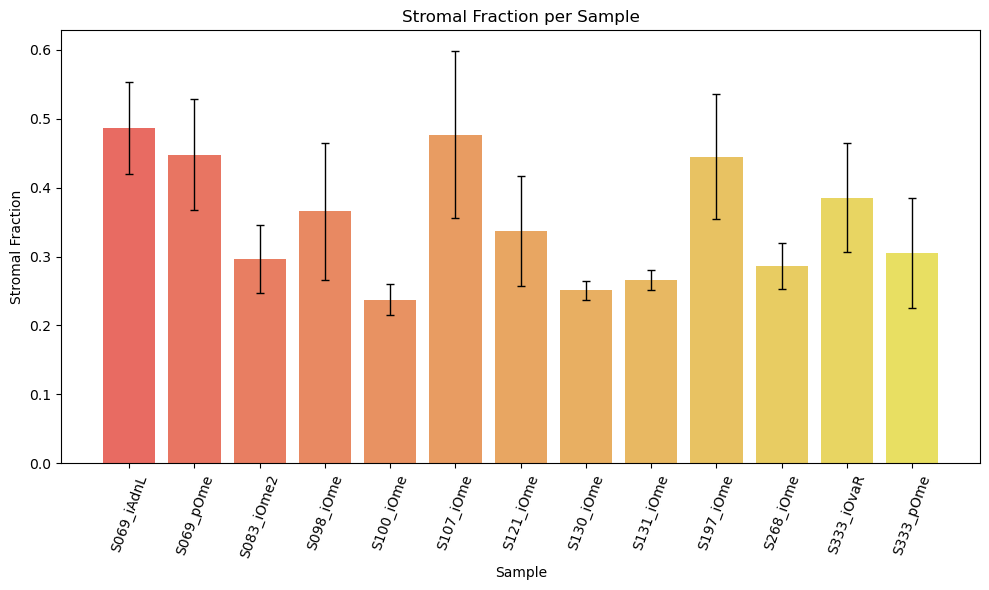

In [5]:
grouped=fibroblasts_proportion.groupby("Sample")["All Stromal"]
# Create a new DataFrame with the mean and variance of the stromal cells proportion
stromal_stats_sample = grouped.agg(["mean", "var", "count"]).reset_index()
#calculate the standard deviation, standard error of the mean, 95% confidence interval
stromal_stats_sample["std"] = np.sqrt(stromal_stats_sample["var"])
stromal_stats_sample["sem"]=stromal_stats_sample["std"] / np.sqrt(stromal_stats_sample["count"])
stromal_stats_sample["ci95"]=1.96*stromal_stats_sample["sem"]
plt.figure(figsize=(10, 6))
sns.barplot(x="Sample", y="mean", data=stromal_stats_sample,palette="autumn",alpha=0.7)
plt.errorbar(
    x=np.arange(len(stromal_stats_sample)),  # x positions
    y=stromal_stats_sample["mean"],
    yerr=stromal_stats_sample["ci95"],
    fmt='none',
    ecolor='black',
    capsize=3,
    linewidth=1.0
)
plt.xticks(rotation=70)
plt.xlabel("Sample")
plt.ylabel("Stromal Fraction")
plt.title("Stromal Fraction per Sample")
plt.tight_layout()

Create dataframes where the cell proportions for stroma and tumor segments will be stored separately, compute the stromal cell statistics for those

In [8]:
stromal_data = fibroblasts_proportion[fibroblasts_proportion["Segment"] == "stroma"]
tumor_data = fibroblasts_proportion[fibroblasts_proportion["Segment"] == "tumor"]

# Group and compute stats for stromal
grouped_stromal = stromal_data.groupby("Sample")["All Stromal"]
stromal_stats_sample_str = grouped_stromal.agg(["mean", "var", "count"]).reset_index()
stromal_stats_sample_str["std"] = np.sqrt(stromal_stats_sample_str["var"])
stromal_stats_sample_str["sem"] = stromal_stats_sample_str["std"] / np.sqrt(stromal_stats_sample_str["count"])
stromal_stats_sample_str["ci95"] = 1.96 * stromal_stats_sample_str["sem"]

# Group and compute stats for tumor
grouped_tumor = tumor_data.groupby("Sample")["All Stromal"]
tumor_stats_sample_tum = grouped_tumor.agg(["mean", "var", "count"]).reset_index()
tumor_stats_sample_tum["std"] = np.sqrt(tumor_stats_sample_tum["var"])
tumor_stats_sample_tum["sem"] = tumor_stats_sample_tum["std"] / np.sqrt(tumor_stats_sample_tum["count"])
tumor_stats_sample_tum["ci95"] = 1.96 * tumor_stats_sample_tum["sem"]

Heatmap for cell proportions in stromal segments by sample

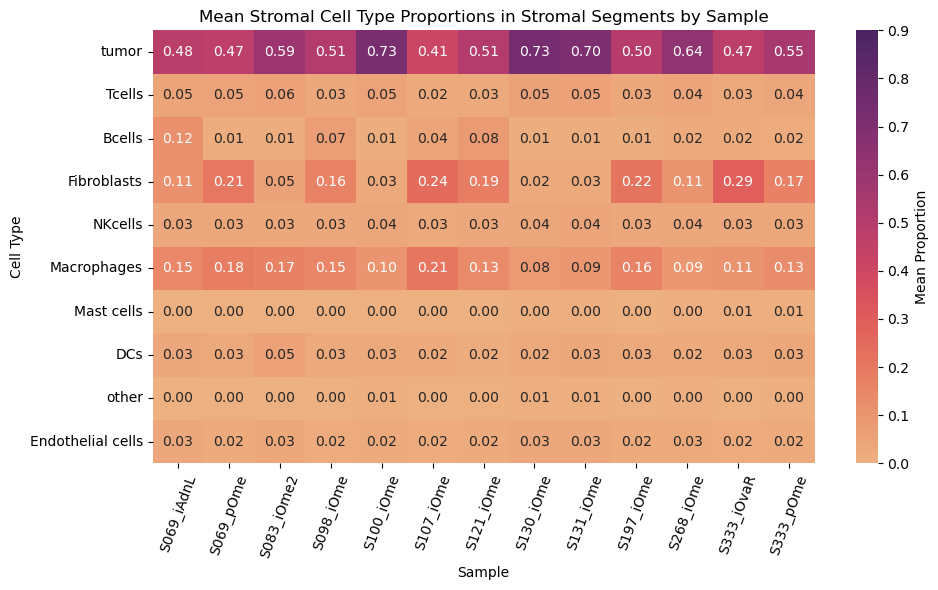

In [11]:
cell_types=cell_types = ["tumor",'Tcells', 'Bcells', 'Fibroblasts', 'NKcells',
              'Macrophages', 'Mast cells', 'DCs', 'other', 'Endothelial cells']

stromal_heatmap_data = stromal_data.groupby("Sample")[cell_types].mean().T

plt.figure(figsize=(10, 6))
sns.heatmap(stromal_heatmap_data, cmap="flare", annot=True, fmt=".2f", vmin=0,vmax=0.9,cbar_kws={'label': 'Mean Proportion'})
plt.title("Mean Stromal Cell Type Proportions in Stromal Segments by Sample")
plt.xlabel("Sample")
plt.xticks(rotation=70)
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

Heatmap for cell proportions in tumor segments by sample

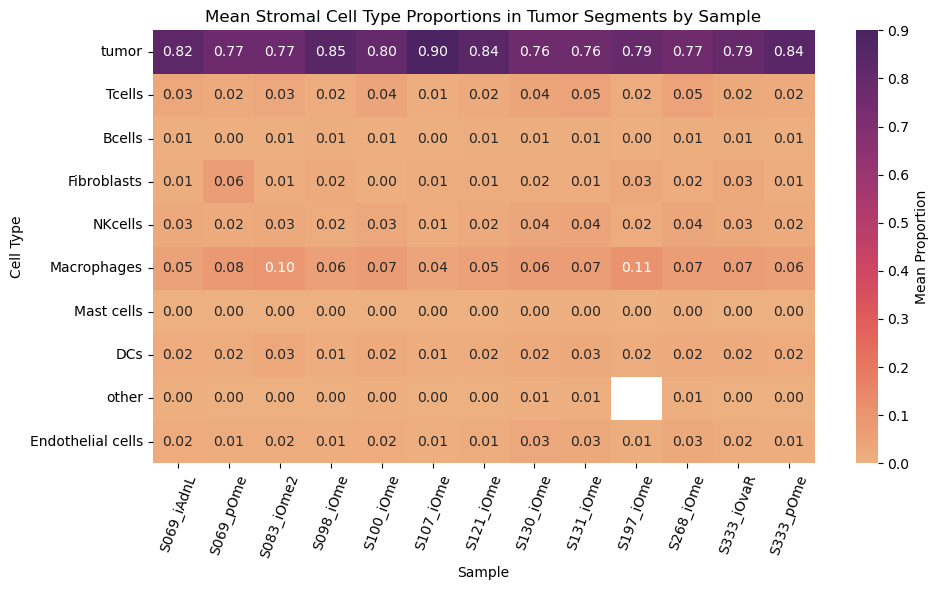

In [12]:
cell_types=cell_types = ["tumor",'Tcells', 'Bcells', 'Fibroblasts', 'NKcells',
              'Macrophages', 'Mast cells', 'DCs', 'other', 'Endothelial cells']

tumor_heatmap_data = tumor_data.groupby("Sample")[cell_types].mean().T

plt.figure(figsize=(10, 6))
sns.heatmap(tumor_heatmap_data, cmap="flare", annot=True, fmt=".2f",vmin=0,vmax=0.9, cbar_kws={'label': 'Mean Proportion'})
plt.title("Mean Stromal Cell Type Proportions in Tumor Segments by Sample")
plt.xlabel("Sample")
plt.xticks(rotation=70)
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

Heatmap showing tumor cell proportion in tumor segments by sample

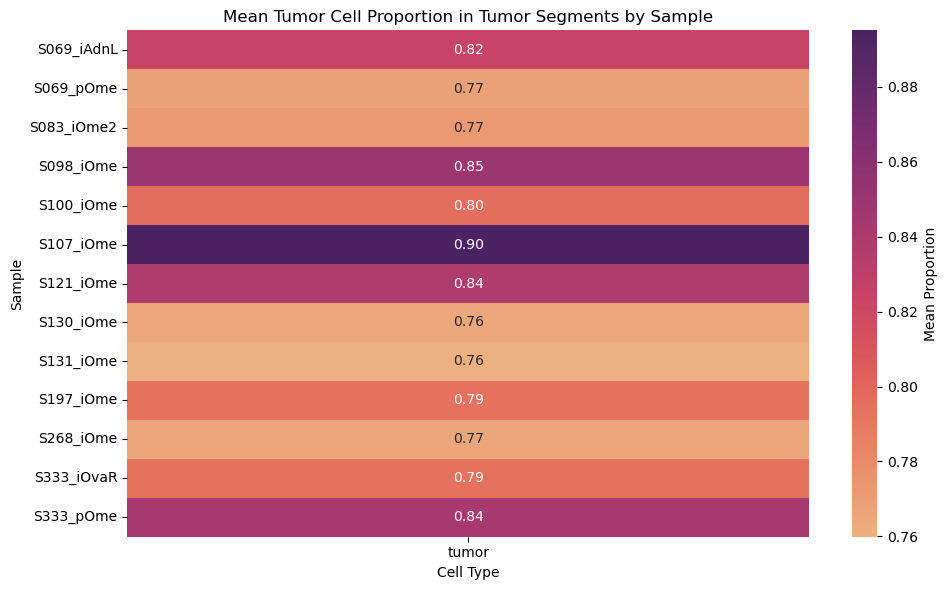

In [13]:

tumor_heatmap_data = tumor_data.groupby("Sample")['tumor'].mean().to_frame()

plt.figure(figsize=(10, 6))
sns.heatmap(tumor_heatmap_data, cmap="flare", annot=True, fmt=".2f", cbar_kws={'label': 'Mean Proportion'})
plt.title("Mean Tumor Cell Proportion in Tumor Segments by Sample")
plt.xlabel("Cell Type")
plt.ylabel("Sample")
plt.tight_layout()
plt.show()

Barplots for stromal cell proportions in stromal and tumor segments

/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/43098044.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sample", y="mean", data=stromal_stats_sample_str,palette="flare",alpha=0.7,ax=ax2)
/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/43098044.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sample", y="mean", data=tumor_stats_sample_tum,palette="flare",alpha=0.7,ax=ax3)


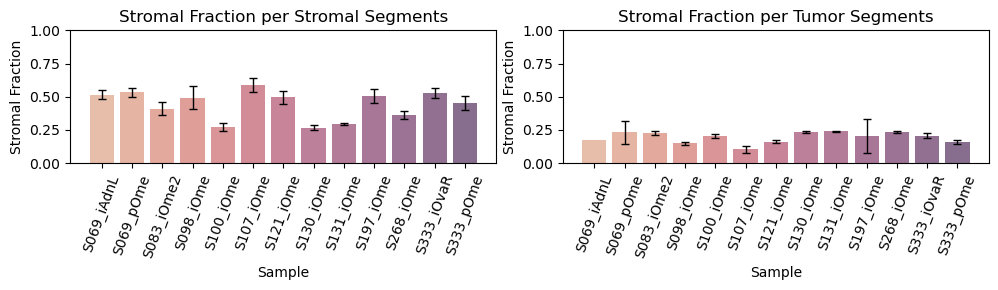

In [14]:
grouped=fibroblasts_proportion.groupby("Sample")["tumor"]
tumor_stats_sample = grouped.agg(["mean", "var", "count"]).reset_index()
tumor_stats_sample["std"] = np.sqrt(tumor_stats_sample["var"])
tumor_stats_sample["sem"]=tumor_stats_sample["std"] / np.sqrt(tumor_stats_sample["count"])
tumor_stats_sample["ci95"]=1.96*tumor_stats_sample["sem"]
fig,(ax2,ax3)=plt.subplots(1,2,figsize=(10, 3))



sns.barplot(x="Sample", y="mean", data=stromal_stats_sample_str,palette="flare",alpha=0.7,ax=ax2)
ax2.errorbar(
    x=np.arange(len(stromal_stats_sample_str)),
    y=stromal_stats_sample_str["mean"],
    yerr=stromal_stats_sample_str["ci95"],
    fmt='none',
    ecolor='black',
    capsize=3,
    linewidth=1.0
)
ax2.set_ylim(0, 1)
#ax2.set_xlabel("Sample")
ax2.set_ylabel("Stromal Fraction")
ax2.set_title("Stromal Fraction per Stromal Segments")

ax2.set_xticks(np.arange(len(stromal_stats_sample_str)))
ax2.set_xticklabels(stromal_stats_sample_str["Sample"], rotation=70)

sns.barplot(x="Sample", y="mean", data=tumor_stats_sample_tum,palette="flare",alpha=0.7,ax=ax3)
ax3.errorbar(
    x=np.arange(len(tumor_stats_sample_tum)),
    y=tumor_stats_sample_tum["mean"],
    yerr=tumor_stats_sample_tum["ci95"],
    fmt='none',
    ecolor='black',
    capsize=3,
    linewidth=1.0
)
ax3.set_ylim(0, 1)
ax3.set_xlabel("Sample")
ax3.set_ylabel("Stromal Fraction")
ax3.set_title("Stromal Fraction per Tumor Segments")

ax3.set_xticks(np.arange(len(tumor_stats_sample_tum)))
ax3.set_xticklabels(tumor_stats_sample_tum["Sample"], rotation=70)
plt.tight_layout()

Computing fibroblasts statistics separately in stromal and tumor segments

In [15]:
tumor_fibroblasts = fibroblasts_proportion[fibroblasts_proportion["Segment"] == "tumor"]
stroma_fibroblasts = fibroblasts_proportion[fibroblasts_proportion["Segment"] == "stroma"]

fibr_stats_tumor=tumor_fibroblasts.groupby("Patient")["Fibroblasts"].agg(["mean", "var"]).reset_index()
fibr_stats_stroma=stroma_fibroblasts.groupby("Patient")["Fibroblasts"].agg(["mean", "var"]).reset_index()
fibr_stats_tumor.columns = ["Patient", "Fibroblasts_mean", "Fibroblasts_var"]
fibr_stats_stroma.columns = ["Patient", "Fibroblasts_mean", "Fibroblasts_var"]


Computing Pearson correlation of different cell type presence in all segments, in tumor segments and in stroma segments separately

<Axes: title={'center': 'Stroma cells'}>

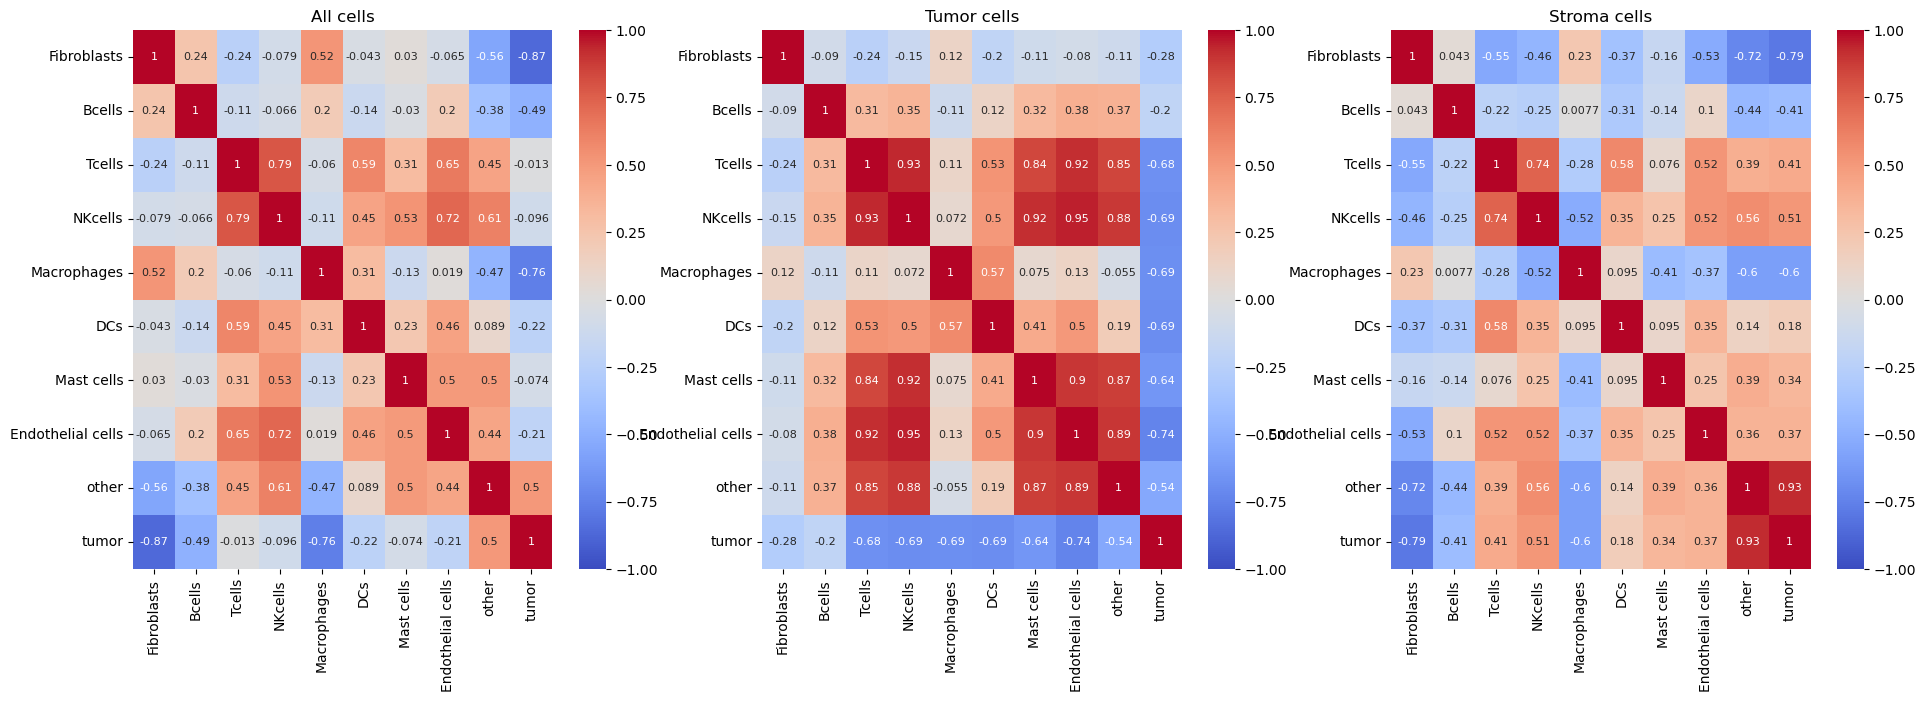

In [16]:
cell_columns = ["Fibroblasts", "Bcells", "Tcells", "NKcells", "Macrophages", "DCs","Mast cells","Endothelial cells","other","tumor"]
corr_data = fibroblasts_proportion[cell_columns]
corr_data_tumor=tumor_fibroblasts[cell_columns]
corr_data_stroma=stroma_fibroblasts[cell_columns]

# Compute correlation matrix
fig,axes=plt.subplots(1,3,figsize=(23,7))
corr_data.dropna()
corr_data_tumor.dropna()
corr_data_stroma.dropna()
corr_matrix = corr_data.corr()
corr_matrix_tumor = corr_data_tumor.corr()
corr_matrix_stroma = corr_data_stroma.corr()

axes[0].set_title("All cells")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1,annot_kws={"size": 8}, ax=axes[0])    
axes[1].set_title("Tumor cells")        
sns.heatmap(corr_matrix_tumor, annot=True, cmap="coolwarm", vmin=-1, vmax=1,annot_kws={"size": 8}, ax=axes[1])
axes[2].set_title("Stroma cells")   
sns.heatmap(corr_matrix_stroma, annot=True, cmap="coolwarm", vmin=-1, vmax=1,annot_kws={"size": 8}, ax=axes[2])

Calculating the Pearson correlation between tumor cell abundance and fibroblast presence within stroma segments, and visualizing their relationship using a scatter plot.

Pearson r = -0.793, p = 5.961e-25


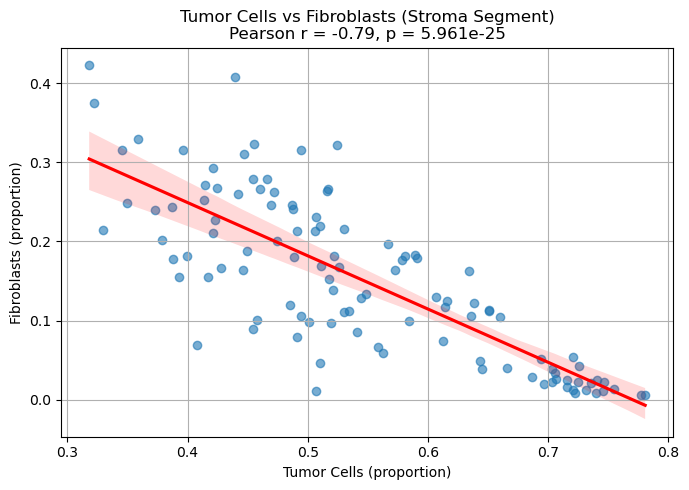

In [17]:
pearson_corr, p_val = pearsonr(stroma_fibroblasts["tumor"], stroma_fibroblasts["Fibroblasts"])
print(f"Pearson r = {pearson_corr:.3f}, p = {p_val:.3e}")
plt.figure(figsize=(7, 5))
sns.regplot(
    data=stroma_fibroblasts,
    x="tumor",
    y="Fibroblasts",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    ci=99  # Confidence interval in percent
)

plt.title(f"Tumor Cells vs Fibroblasts (Stroma Segment)\nPearson r = {pearson_corr:.2f}, p = {p_val:.3e}")
plt.xlabel("Tumor Cells (proportion)")
plt.ylabel("Fibroblasts (proportion)")
plt.grid(True)
plt.tight_layout()
plt.show()

Violin plots of fibroblasts and tumor cells proportions in stroma ad tumor segments

/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/3246549694.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=fibroblasts_proportion, x='Segment', y='Fibroblasts', palette='flare',alpha=0.7)
/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/3246549694.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=fibroblasts_proportion, x='Segment', y='tumor', palette='cool',alpha=0.7)


<Axes: title={'center': 'Tumor cells proportion in tumor and stroma segments'}, xlabel='Segment', ylabel='Tumor cells proportion'>

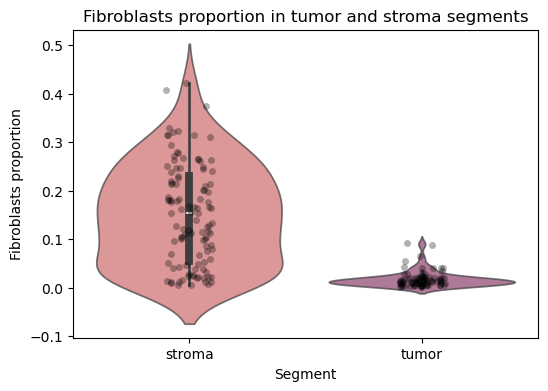

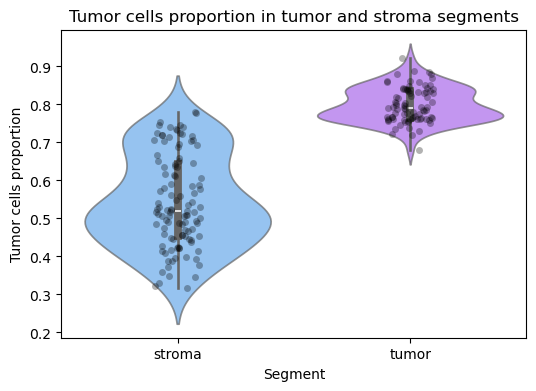

In [18]:
plt.figure(figsize=(6, 4))
plt.title("Fibroblasts proportion in tumor and stroma segments")
plt.ylabel("Fibroblasts proportion")
sns.violinplot(data=fibroblasts_proportion, x='Segment', y='Fibroblasts', palette='flare',alpha=0.7)
sns.stripplot(data=fibroblasts_proportion, x='Segment', y='Fibroblasts', color='black', alpha=0.3, jitter=True, size=5)
#sns.stripplot(data=fibroblasts_proportion, x='Segment', y='Fibroblasts', color='black', alpha=0.6, jitter=False, size=4)
plt.figure(figsize=(6, 4))
plt.title("Tumor cells proportion in tumor and stroma segments")
plt.ylabel("Tumor cells proportion")
sns.violinplot(data=fibroblasts_proportion, x='Segment', y='tumor', palette='cool',alpha=0.7)
sns.stripplot(data=fibroblasts_proportion, x='Segment', y='tumor', color='black', alpha=0.3, jitter=True, size=5)

Violin plots of T cell proportion in tumor and stroma segments

/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/205449645.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=fibroblasts_proportion, x='Segment', y='Tcells', palette='flare',alpha=0.7)


<Axes: title={'center': 'T cells proportion in tumor and stroma segments'}, xlabel='Segment', ylabel='T cells proportion'>

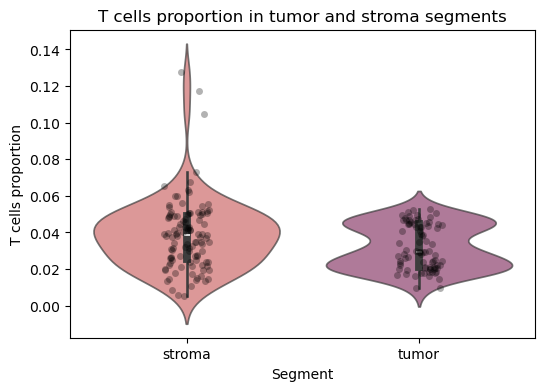

In [19]:
plt.figure(figsize=(6, 4))
plt.title("T cells proportion in tumor and stroma segments")
plt.ylabel("T cells proportion")
sns.violinplot(data=fibroblasts_proportion, x='Segment', y='Tcells', palette='flare',alpha=0.7)
sns.stripplot(data=fibroblasts_proportion, x='Segment', y='Tcells', color='black', alpha=0.3, jitter=True, size=5)

Loading the datasets with ssGSEA scores for all cells, fibroblasts and tumor cells

In [20]:
pathway_all = pd.read_csv("ssgsea_norm_harmony_batch_corr_all_msigdb.csv")
pathway_fibr= pd.read_csv("ssgsea_norm_harmony_batch_corr_deconv_Fibroblasts_msigdb.csv")
pathway_tumor=pd.read_csv("ssgsea_norm_harmony_batch_corr_deconv_tumor_msigdb.csv")
pathway_all.head()

pathway                 dcc_filename  ssgsea_score  \
0           BIOCARTA_41BB_PATHWAY  DSP-1001660016604-A-A02.dcc      0.127598   
1           BIOCARTA_ACE2_PATHWAY  DSP-1001660016604-A-A02.dcc      0.059046   
2  BIOCARTA_ACETAMINOPHEN_PATHWAY  DSP-1001660016604-A-A02.dcc     -0.159118   
3            BIOCARTA_ACH_PATHWAY  DSP-1001660016604-A-A02.dcc      0.104318   
4         BIOCARTA_ACTINY_PATHWAY  DSP-1001660016604-A-A02.dcc      0.219377   

  expr_signal  Roi Segment     Sample NACT_status Annotation_cell  \
0         all    1  stroma  S130_iOme        post        CD8_Iba1   
1         all    1  stroma  S130_iOme        post        CD8_Iba1   
2         all    1  stroma  S130_iOme        post        CD8_Iba1   
3         all    1  stroma  S130_iOme        post        CD8_Iba1   
4         all    1  stroma  S130_iOme        post        CD8_Iba1   

  Segment_geomx Patient     Site  
0           tsi    S130  Omentum  
1           tsi    S130  Omentum  
2           tsi    S130  Omentum  
3           tsi    S130  Omentum  
4           tsi    S130  Omentum

In [25]:
segment_stroma_all=pathway_all[pathway_all["Segment"]=="stroma"]
segment_tumor_all=pathway_all[pathway_all["Segment"]=="stroma"]


p_values = {}
for pathway, group in pathway_all.groupby("pathway"):
    score_stroma = group[group["Segment"] == "stroma"]["ssgsea_score"]  # Adjust column names
    score_tumor = group[group["Segment"] == "tumor"]["ssgsea_score"]
    t_stat, p_val = ttest_ind(score_stroma, score_tumor, equal_var=False)  # Welch’s t-test
    p_values[pathway] = p_val
    #stats_wilcoxon, p_val_wilcoxon = wilcoxon(score_stroma, score_tumor)
    #mean_stroma = score_stroma.mean()
    #mean_tumor = score_tumor.mean()

# Convert to DataFrame and adjust p-values
p_values_df = pd.DataFrame.from_dict(p_values, orient="index", columns=["p_value"])
p_values_df["adj_p_value"] = sm.stats.multipletests(p_values_df["p_value"], method="fdr_bh")[1]
p_values_df["mean_stroma"] = [score_stroma.mean() for pathway, group in pathway_all.groupby("pathway") for score_stroma in [group[group["Segment"] == "stroma"]["ssgsea_score"].mean()]]
p_values_df["mean_tumor"] = [score_stroma.mean() for pathway, group in pathway_all.groupby("pathway") for score_stroma in [group[group["Segment"] == "tumor"]["ssgsea_score"].mean()]]
p_values_df["mean_difference"] = p_values_df["mean_stroma"] - p_values_df["mean_tumor"]
#p_values_df["stats_wilcoxon"]= stats_wilcoxon
# calculate fold change in stroma versus the tumor
# Get significantly different pathways
sig_pathways = p_values_df[p_values_df["adj_p_value"] < 0.05]
#print(sig_pathways.head())  # Show significant pathways
sig_pathways_sorted = sig_pathways.sort_values(by="mean_difference", ascending=False)
sig_pathways_sorted.head(20) 

p_value  \
BIOCARTA_TCYTOTOXIC_PATHWAY                         1.211084e-31   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...  2.615196e-29   
BIOCARTA_THELPER_PATHWAY                            2.189629e-31   
BIOCARTA_NEUTROPHIL_PATHWAY                         5.079108e-26   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                 1.241177e-22   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...  2.104747e-27   
GOBP_NEGATIVE_REGULATION_OF_MAST_CELL_DEGRANULA...  9.093321e-23   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS   1.137888e-19   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...  5.494436e-34   
GOBP_NEGATIVE_REGULATION_OF_T_CELL_MEDIATED_CYT...  4.886208e-23   
BIOCARTA_LYM_PATHWAY                                1.789724e-26   
BIOCARTA_LYMPHOCYTE_PATHWAY                         1.018297e-27   
GOBP_POSITIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_...  8.948744e-24   
GOBP_REGULATION_OF_ENDOTHELIAL_TUBE_MORPHOGENESIS   1.234003e-23   
GOBP_REGULATION_OF_MYELOID_DENDRITIC_CELL_ACTIV...  2.072333e-24   
GOBP_REGULATION_OF_DENDRITIC_CELL_ANTIGEN_PROCE...  3.410012e-37   
BIOCARTA_MONOCYTE_PATHWAY                           9.661410e-28   
GOBP_NEGATIVE_REGULATION_OF_LEUKOCYTE_DEGRANULA...  5.897159e-27   
GOBP_GRANULOCYTE_COLONY_STIMULATING_FACTOR_PROD...  8.202419e-28   
GOBP_NEGATIVE_REGULATION_OF_MYELOID_LEUKOCYTE_M...  5.888738e-24   

                                                     adj_p_value  mean_stroma  \
BIOCARTA_TCYTOTOXIC_PATHWAY                         6.763307e-30     0.227456   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...  9.284675e-28     0.162410   
BIOCARTA_THELPER_PATHWAY                            1.149918e-29     0.247302   
BIOCARTA_NEUTROPHIL_PATHWAY                         1.097475e-24     0.286623   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                 1.723737e-21     0.150458   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...  5.696467e-26     0.204798   
GOBP_NEGATIVE_REGULATION_OF_MAST_CELL_DEGRANULA...  1.271782e-21     0.195170   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS   1.145108e-18     0.125942   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...  5.379121e-32     0.030949   
GOBP_NEGATIVE_REGULATION_OF_T_CELL_MEDIATED_CYT...  7.135843e-22     0.202542   
BIOCARTA_LYM_PATHWAY                                4.149856e-25     0.224810   
BIOCARTA_LYMPHOCYTE_PATHWAY                         2.863510e-26     0.320563   
GOBP_POSITIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_...  1.424971e-22     0.351021   
GOBP_REGULATION_OF_ENDOTHELIAL_TUBE_MORPHOGENESIS   1.941597e-22     0.179192   
GOBP_REGULATION_OF_MYELOID_DENDRITIC_CELL_ACTIV...  3.684665e-23     0.066042   
GOBP_REGULATION_OF_DENDRITIC_CELL_ANTIGEN_PROCE...  8.723030e-35     0.232632   
BIOCARTA_MONOCYTE_PATHWAY                           2.746057e-26     0.276984   
GOBP_NEGATIVE_REGULATION_OF_LEUKOCYTE_DEGRANULA...  1.503681e-25     0.236462   
GOBP_GRANULOCYTE_COLONY_STIMULATING_FACTOR_PROD...  2.365280e-26    -0.051597   
GOBP_NEGATIVE_REGULATION_OF_MYELOID_LEUKOCYTE_M...  9.543453e-23     0.183797   

                                                    mean_tumor  \
BIOCARTA_TCYTOTOXIC_PATHWAY                           0.006446   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...   -0.047505   
BIOCARTA_THELPER_PATHWAY                              0.040361   
BIOCARTA_NEUTROPHIL_PATHWAY                           0.098466   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                  -0.031909   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...    0.023161   
GOBP_NEGATIVE_REGULATION_OF_MAST_CELL_DEGRANULA...    0.015701   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS    -0.053452   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...   -0.145027   
GOBP_NEGATIVE_REGULATION_OF_T_CELL_MEDIATED_CYT...    0.027978   
BIOCARTA_LYM_PATHWAY                                  0.051369   
BIOCARTA_LYMPHOCYTE_PATHWAY                           0.149686   
GOBP_POSITIVE_REGULATION_OF_CD8_POSITIVE_ALPHA_...    0.180685   
GO

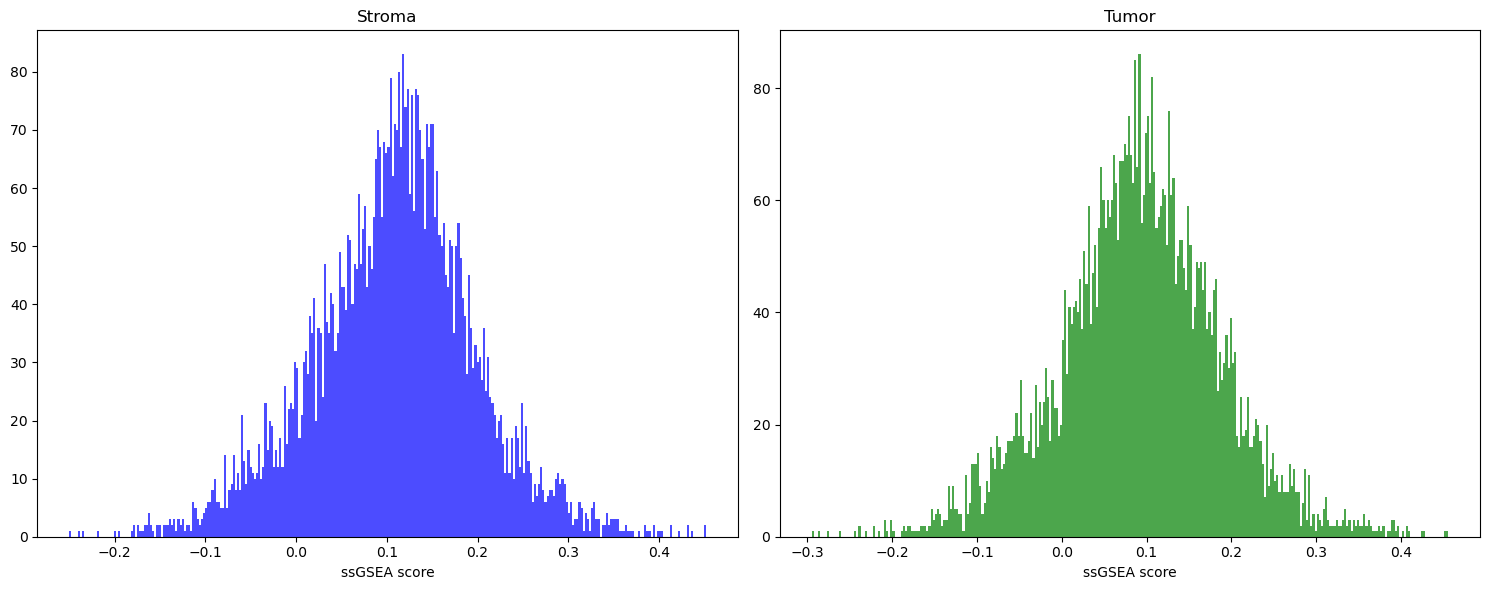

In [26]:
fig,axes=plt.subplots(1,2,figsize=(15,6))

axes[0].hist(sig_pathways_sorted["mean_stroma"],bins=300,color='blue', alpha=0.7)
axes[0].set_title("Stroma")
axes[0].set_xlabel("ssGSEA score")
axes[1].hist(sig_pathways_sorted["mean_tumor"],bins=300,color='green', alpha=0.7)
axes[1].set_title("Tumor")      
axes[1].set_xlabel("ssGSEA score")

plt.tight_layout()
plt.show()

In [27]:
p_values_fibr = {}
for pathway, group in pathway_fibr.groupby("pathway"):
    score_stroma_fibr = group[group["Segment"] == "stroma"]["ssgsea_score"]  # Adjust column names
    score_tumor_fibr = group[group["Segment"] == "tumor"]["ssgsea_score"]
    t_stat_fibr, p_val_fibr = ttest_ind(score_stroma_fibr, score_tumor_fibr, equal_var=False)  # Welch’s t-test
    p_values_fibr[pathway] = p_val_fibr

# Convert to DataFrame and adjust p-values
p_values_fibr_df = pd.DataFrame.from_dict(p_values_fibr, orient="index", columns=["p_value_fibr"])
p_values_fibr_df["adj_p_value_fibr"] = sm.stats.multipletests(p_values_fibr_df["p_value_fibr"], method="fdr_bh")[1]
p_values_fibr_df["mean_stroma_fibr"] = [score_stroma_fibr.mean() for pathway, group in pathway_fibr.groupby("pathway") for score_stroma_fibr in [group[group["Segment"] == "stroma"]["ssgsea_score"].mean()]]
p_values_fibr_df["mean_tumor_fibr"] = [score_tumor_fibr.mean() for pathway, group in pathway_fibr.groupby("pathway") for score_tumor_fibr in [group[group["Segment"] == "tumor"]["ssgsea_score"].mean()]]
p_values_fibr_df["mean_difference_fibr"] = p_values_fibr_df["mean_stroma_fibr"] - p_values_fibr_df["mean_tumor_fibr"]

# Get significantly different pathways in fibroblast analysis
sig_pathways_fibr = p_values_fibr_df[p_values_fibr_df["adj_p_value_fibr"] < 0.05]
sig_pathways_fibr_sorted = sig_pathways_fibr.sort_values(by="mean_difference_fibr", ascending=False)

sig_pathways_fibr_sorted.head(20)


p_value_fibr  \
GOBP_REGULATION_OF_CARDIAC_MUSCLE_CELL_ACTION_P...  5.734585e-15   
GOBP_REGULATION_OF_MELANOCYTE_DIFFERENTIATION       3.380142e-10   
GOBP_REGULATION_OF_ENDOTHELIAL_TUBE_MORPHOGENESIS   1.540338e-15   
GOBP_CAVEOLA_ASSEMBLY                               6.419184e-11   
GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_TO_MESEN...  1.440910e-10   
GOBP_DICHOTOMOUS_SUBDIVISION_OF_TERMINAL_UNITS_...  4.694699e-10   
GOBP_TRICUSPID_VALVE_MORPHOGENESIS                  5.559536e-09   
GOBP_TRICUSPID_VALVE_DEVELOPMENT                    5.559536e-09   
GOBP_REGULATION_OF_EPITHELIAL_TO_MESENCHYMAL_TR...  5.436241e-15   
GOBP_REGULATION_OF_GLOMERULAR_FILTRATION            6.522681e-18   
GOBP_COMMON_PARTNER_SMAD_PROTEIN_PHOSPHORYLATION    8.794727e-08   
GOBP_RIBOSOME_ASSOCIATED_UBIQUITIN_DEPENDENT_PR...  1.132137e-08   
GOBP_RESCUE_OF_STALLED_RIBOSOME                     1.132137e-08   
GOBP_POSITIVE_REGULATION_OF_MELANOCYTE_DIFFEREN...  2.403194e-08   
GOBP_RIGHTING_REFLEX                                8.875786e-09   
GOBP_SYNAPTIC_VESICLE_BUDDING                       2.055315e-08   
GOBP_POSITIVE_REGULATION_OF_ER_ASSOCIATED_UBIQU...  2.494010e-07   
GOBP_PURKINJE_MYOCYTE_TO_VENTRICULAR_CARDIAC_MU...  2.671081e-10   
GOBP_NEGATIVE_REGULATION_OF_PINOCYTOSIS             1.633202e-12   
GOBP_DICHOTOMOUS_SUBDIVISION_OF_AN_EPITHELIAL_T...  1.196028e-09   

                                                    adj_p_value_fibr  \
GOBP_REGULATION_OF_CARDIAC_MUSCLE_CELL_ACTION_P...      4.836490e-12   
GOBP_REGULATION_OF_MELANOCYTE_DIFFERENTIATION           1.816295e-08   
GOBP_REGULATION_OF_ENDOTHELIAL_TUBE_MORPHOGENESIS       1.972659e-12   
GOBP_CAVEOLA_ASSEMBLY                                   5.223809e-09   
GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_TO_MESEN...      9.304162e-09   
GOBP_DICHOTOMOUS_SUBDIVISION_OF_TERMINAL_UNITS_...      2.389011e-08   
GOBP_TRICUSPID_VALVE_MORPHOGENESIS                      1.794969e-07   
GOBP_TRICUSPID_VALVE_DEVELOPMENT                        1.794969e-07   
GOBP_REGULATION_OF_EPITHELIAL_TO_MESENCHYMAL_TR...      4.836490e-12   
GOBP_REGULATION_OF_GLOMERULAR_FILTRATION                2.506014e-14   
GOBP_COMMON_PARTNER_SMAD_PROTEIN_PHOSPHORYLATION        1.702234e-06   
GOBP_RIBOSOME_ASSOCIATED_UBIQUITIN_DEPENDENT_PR...      3.186572e-07   
GOBP_RESCUE_OF_STALLED_RIBOSOME                         3.186572e-07   
GOBP_POSITIVE_REGULATION_OF_MELANOCYTE_DIFFEREN...      5.995502e-07   
GOBP_RIGHTING_REFLEX                                    2.643471e-07   
GOBP_SYNAPTIC_VESICLE_BUDDING                           5.212225e-07   
GOBP_POSITIVE_REGULATION_OF_ER_ASSOCIATED_UBIQU...      3.967697e-06   
GOBP_PURKINJE_MYOCYTE_TO_VENTRICULAR_CARDIAC_MU...      1.519863e-08   
GOBP_NEGATIVE_REGULATION_OF_PINOCYTOSIS                 3.217826e-10   
GOBP_DICHOTOMOUS_SUBDIVISION_OF_AN_EPITHELIAL_T...      5.221750e-08   

                                                    mean_stroma_fibr  \
GOBP_REGULATION_OF_CARDIAC_MUSCLE_CELL_ACTION_P...          0.288600   
GOBP_REGULATION_OF_MELANOCYTE_DIFFERENTIATION               0.126451   
GOBP_REGULATION_OF_ENDOTHELIAL_TUBE_MORPHOGENESIS           0.315714   
GOBP_CAVEOLA_ASSEMBLY                                       0.314626   
GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_TO_MESEN...          0.360838   
GOBP_DICHOTOMOUS_SUBDIVISION_OF_TERMINAL_UNITS_...          0.352665   
GOBP_TRICUSPID_VALVE_MORPHOGENESIS                          0.068239   
GOBP_TRICUSPID_VALVE_DEVELOPMENT                            0.068239   
GOBP_REGULATION_OF_EPITHELIAL_TO_MESENCHYMAL_TR...          0.388466   
GOBP_REGULATION_OF_GLOMERULAR_FILTRATION                    0.241241   
GOBP_COMMON_PARTNER_SMAD_PROTEIN_PHOSPHORYLATION            0.354992   
GOBP_RIBOSOME_ASSOCIATED_UBIQUITIN_DEPENDENT_PR...          0.107212   
GOBP_RESCUE_OF_STALLED_RIBOSOME                             0.107212   
GOBP_POSITIVE_REGULATION_OF_MELANOCYTE_DIFFEREN...          0.084706   
GOBP_RIGHTING_REFLEX          

In [28]:
p_values_tumor = {}
for pathway, group in pathway_tumor.groupby("pathway"):
    score_stroma_tumor = group[group["Segment"] == "stroma"]["ssgsea_score"]  # Adjust column names
    score_tumor_tumor = group[group["Segment"] == "tumor"]["ssgsea_score"]
    t_stat_tumor, p_val_tumor = ttest_ind(score_stroma_tumor, score_tumor_tumor, equal_var=False)  # Welch’s t-test
    p_values_tumor[pathway] = p_val_tumor

# Convert to DataFrame and adjust p-values
p_values_tumor_df = pd.DataFrame.from_dict(p_values_tumor, orient="index", columns=["p_value_tumor"])
p_values_tumor_df["adj_p_value_tumor"] = sm.stats.multipletests(p_values_tumor_df["p_value_tumor"], method="fdr_bh")[1]
p_values_tumor_df["mean_stroma_tumor"] = [score_stroma_tumor.mean() for pathway, group in pathway_tumor.groupby("pathway") for score_stroma_tumor in [group[group["Segment"] == "stroma"]["ssgsea_score"].mean()]]
p_values_tumor_df["mean_tumor_tumor"] = [score_tumor_tumor.mean() for pathway, group in pathway_tumor.groupby("pathway") for score_tumor_tumor in [group[group["Segment"] == "tumor"]["ssgsea_score"].mean()]]
p_values_tumor_df["mean_difference_tumor"] = p_values_tumor_df["mean_stroma_tumor"] - p_values_tumor_df["mean_tumor_tumor"]

# Get significantly different pathways in tumor-specific analysis
sig_pathways_tumor = p_values_tumor_df[p_values_tumor_df["adj_p_value_tumor"] < 0.05]
sig_pathways_tumor_sorted = sig_pathways_tumor.sort_values(by="mean_difference_tumor", ascending=False)

sig_pathways_tumor_sorted.head(10)


p_value_tumor  \
GOBP_AMACRINE_CELL_DIFFERENTIATION                   4.509840e-24   
GOBP_EQUILIBRIOCEPTION                               2.864368e-25   
GOBP_BRUSH_BORDER_ASSEMBLY                           1.963114e-21   
GOBP_LIPID_HYDROXYLATION                             3.339848e-19   
GOBP_OMEGA_HYDROXYLASE_P450_PATHWAY                  4.474985e-22   
GOBP_NEUROTRANSMITTER_LOADING_INTO_SYNAPTIC_VES...   1.096651e-16   
GOBP_MONOTERPENOID_METABOLIC_PROCESS                 2.009419e-16   
GOBP_MYCOTOXIN_METABOLIC_PROCESS                     8.500611e-23   
GOBP_NEGATIVE_REGULATION_OF_FIBRINOLYSIS             4.657898e-22   
GOBP_EYE_PIGMENTATION                                5.297828e-16   

                                                    adj_p_value_tumor  \
GOBP_AMACRINE_CELL_DIFFERENTIATION                       1.029172e-21   
GOBP_EQUILIBRIOCEPTION                                   8.889852e-23   
GOBP_BRUSH_BORDER_ASSEMBLY                               1.603348e-19   
GOBP_LIPID_HYDROXYLATION                                 1.245860e-17   
GOBP_OMEGA_HYDROXYLASE_P450_PATHWAY                      4.451463e-20   
GOBP_NEUROTRANSMITTER_LOADING_INTO_SYNAPTIC_VES...       2.080418e-15   
GOBP_MONOTERPENOID_METABOLIC_PROCESS                     3.535393e-15   
GOBP_MYCOTOXIN_METABOLIC_PROCESS                         1.244457e-20   
GOBP_NEGATIVE_REGULATION_OF_FIBRINOLYSIS                 4.574763e-20   
GOBP_EYE_PIGMENTATION                                    8.091702e-15   

                                                    mean_stroma_tumor  \
GOBP_AMACRINE_CELL_DIFFERENTIATION                           0.150676   
GOBP_EQUILIBRIOCEPTION                                       0.013197   
GOBP_BRUSH_BORDER_ASSEMBLY                                   0.050355   
GOBP_LIPID_HYDROXYLATION                                     0.129588   
GOBP_OMEGA_HYDROXYLASE_P450_PATHWAY                          0.114817   
GOBP_NEUROTRANSMITTER_LOADING_INTO_SYNAPTIC_VES...           0.036416   
GOBP_MONOTERPENOID_METABOLIC_PROCESS                         0.165388   
GOBP_MYCOTOXIN_METABOLIC_PROCESS                             0.190091   
GOBP_NEGATIVE_REGULATION_OF_FIBRINOLYSIS                    -0.095558   
GOBP_EYE_PIGMENTATION                                        0.133339   

                                                    mean_tumor_tumor  \
GOBP_AMACRINE_CELL_DIFFERENTIATION                         -0.051317   
GOBP_EQUILIBRIOCEPTION                                     -0.147519   
GOBP_BRUSH_BORDER_ASSEMBLY                                 -0.110338   
GOBP_LIPID_HYDROXYLATION                                   -0.029639   
GOBP_OMEGA_HYDROXYLASE_P450_PATHWAY                        -0.039600   
GOBP_NEUROTRANSMITTER_LOADING_INTO_SYNAPTIC_VES...         -0.111719   
GOBP_MONOTERPENOID_METABOLIC_PROCESS                        0.018876   
GOBP_MYCOTOXIN_METABOLIC_PROCESS                            0.046134   
GOBP_NEGATIVE_REGULATION_OF_FIBRINOLYSIS                   -0.228418   
GOBP_EYE_PIGMENTATION                                       0.000710   

                                                    mean_difference_tumor  
GOBP_AMACRINE_CELL_DIFFERENTIATION                               0.201993  
GOBP_EQUILIBRIOCEPTION                                           0.160716  
GOBP_BRUSH_BORDER_ASSEMBLY                                       0.160693  
GOBP_LIPID_HYDROXYLATION                                         0.159228  
GOBP_OMEGA_HYDROXYLASE_P450_PATHWAY                              0.154417  
GOBP_NEUROTRANSMITTER_LOADING_INTO_SYNAPTIC_VES...               0.148134  
GOBP_MONOTERPENOID_METABOLIC_PROCESS                             0.146512  
GOBP_MYCOTOXIN_METABOLIC_PROCESS                                 0.143957  
GOBP_NEGATIVE_REGULATION_OF_FIBRINOLYSIS                         0.132859  
GOBP_EYE_PIGMENTATION                                            0.132629

In [29]:
merged_stroma = p_values_df.merge(p_values_fibr_df, left_index=True, right_index=True, suffixes=("_all", "_fibr"))

# Keep only significant pathways in both analyses
sig_merged_stroma = merged_stroma[
    (merged_stroma["adj_p_value"] < 0.05) & (merged_stroma["adj_p_value_fibr"] < 0.05)
]

sig_merged_stroma_sorted = sig_merged_stroma.sort_values(by="mean_difference", ascending=False)

sig_merged_stroma_sorted.head(10)

p_value  \
BIOCARTA_TCYTOTOXIC_PATHWAY                         1.211084e-31   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...  2.615196e-29   
BIOCARTA_THELPER_PATHWAY                            2.189629e-31   
BIOCARTA_NEUTROPHIL_PATHWAY                         5.079108e-26   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                 1.241177e-22   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...  2.104747e-27   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS   1.137888e-19   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...  5.494436e-34   
BIOCARTA_LYM_PATHWAY                                1.789724e-26   
BIOCARTA_LYMPHOCYTE_PATHWAY                         1.018297e-27   

                                                     adj_p_value  mean_stroma  \
BIOCARTA_TCYTOTOXIC_PATHWAY                         6.763307e-30     0.227456   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...  9.284675e-28     0.162410   
BIOCARTA_THELPER_PATHWAY                            1.149918e-29     0.247302   
BIOCARTA_NEUTROPHIL_PATHWAY                         1.097475e-24     0.286623   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                 1.723737e-21     0.150458   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...  5.696467e-26     0.204798   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS   1.145108e-18     0.125942   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...  5.379121e-32     0.030949   
BIOCARTA_LYM_PATHWAY                                4.149856e-25     0.224810   
BIOCARTA_LYMPHOCYTE_PATHWAY                         2.863510e-26     0.320563   

                                                    mean_tumor  \
BIOCARTA_TCYTOTOXIC_PATHWAY                           0.006446   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...   -0.047505   
BIOCARTA_THELPER_PATHWAY                              0.040361   
BIOCARTA_NEUTROPHIL_PATHWAY                           0.098466   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                  -0.031909   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...    0.023161   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS    -0.053452   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...   -0.145027   
BIOCARTA_LYM_PATHWAY                                  0.051369   
BIOCARTA_LYMPHOCYTE_PATHWAY                           0.149686   

                                                    mean_difference  \
BIOCARTA_TCYTOTOXIC_PATHWAY                                0.221009   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...         0.209915   
BIOCARTA_THELPER_PATHWAY                                   0.206941   
BIOCARTA_NEUTROPHIL_PATHWAY                                0.188157   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                        0.182367   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...         0.181638   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS          0.179394   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...         0.175976   
BIOCARTA_LYM_PATHWAY                                       0.173441   
BIOCARTA_LYMPHOCYTE_PATHWAY                                0.170877   

                                                    p_value_fibr  \
BIOCARTA_TCYTOTOXIC_PATHWAY                         1.710324e-04   
GOBP_ANGIOGENESIS_INVOLVED_IN_CORONARY_VASCULAR...  2.690024e-10   
BIOCARTA_THELPER_PATHWAY                            1.730406e-04   
BIOCARTA_NEUTROPHIL_PATHWAY                         3.612137e-03   
GOBP_NATURAL_KILLER_CELL_CHEMOTAXIS                 4.453577e-03   
GOBP_WOUND_HEALING_INVOLVED_IN_INFLAMMATORY_RES...  1.052023e-05   
GOBP_REGULATION_OF_NATURAL_KILLER_CELL_CHEMOTAXIS   9.250413e-06   
GOBP_MACROPHAGE_COLONY_STIMULATING_FACTOR_PRODU...  4.049802e-03   
BIOCARTA_LYM_PATHWAY                                1.279244e-04   
BIOCARTA_LYMPHOCYTE_PATHWAY                         2.046798e-02   

                                                    adj_p_value_fibr  \
BIOCARTA_TCYTOTOXIC_PATHWAY                             9.120146e-04   
GOBP_ANGIOGENE

In [31]:
tumor_proportion = pd.read_csv("bp_res_mid_lvl_ct_ct_fraction.csv")
tumor_stats=tumor_proportion.groupby("Patient")["tumor"].agg(["mean", "var"]).reset_index()
tumor_stats.columns = ["Patient", "tumor_mean", "tumor_var"]

In [32]:

df = pd.read_csv("ssgsea_norm_harmony_batch_corr_deconv_Fibroblasts_msigdb.csv")


Loading the clinical data for further usage in the code

In [24]:

clinical_df = pd.read_csv("9_eyemt_patient_clinical_data.csv")  # replace with your filename
geomx_metadata = pd.read_csv("geomx_metadata.csv")        # replace with your filename

# Select only the relevant columns from clinical data
clinical_subset = clinical_df[["Sample", "PFS_quartile", "OS_quartile", "BRCA_status", "HRP_status"]]
clinical_subset = clinical_subset.drop_duplicates(subset="Sample")
# Merge on the 'Sample' column
#merged_df = pd.merge(geomx_metadata, clinical_subset, on="Sample", how="left")

# Save the result
#merged_df.to_csv("geomx_with_clinical.csv", index=False)
#clinical_subset
merged_df = pd.merge(geomx_metadata, clinical_subset, on="Sample", how="left")
merged_df.to_csv("geomx_metadata_modified.csv", index=False)

Computing the fibroblasts statistics in stromal and tumor segments

In [22]:

stromal_data = fibroblasts_proportion[fibroblasts_proportion["Segment"] == "stroma"]
tumor_data = fibroblasts_proportion[fibroblasts_proportion["Segment"] == "tumor"]

# Group and compute stats for fibroblasts in stroma

grouped_stromal_fibroblasts = stromal_data.groupby("Sample")["Fibroblasts"]
stromal_stats_sample_fibr = grouped_stromal_fibroblasts.agg(["mean", "var", "count"]).reset_index()
stromal_stats_sample_fibr["std"] = np.sqrt(stromal_stats_sample_fibr["var"])
stromal_stats_sample_fibr["sem"] = stromal_stats_sample_fibr["std"] / np.sqrt(stromal_stats_sample_fibr["count"])
stromal_stats_sample_fibr["ci95"] = 1.96 * stromal_stats_sample_fibr["sem"]

# Group and compute stats for fibroblasts in tumor
grouped_tumor_fibroblasts = tumor_data.groupby("Sample")["Fibroblasts"]
tumor_stats_sample_fibr = grouped_tumor_fibroblasts.agg(["mean", "var", "count"]).reset_index()
tumor_stats_sample_fibr["std"] = np.sqrt(tumor_stats_sample_fibr["var"])
tumor_stats_sample_fibr["sem"] = tumor_stats_sample_fibr["std"] / np.sqrt(tumor_stats_sample_fibr["count"])
tumor_stats_sample_fibr["ci95"] = 1.96 * tumor_stats_sample_fibr["sem"]

/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/427605833.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sample", y="mean", data=stromal_stats_sample_fibr,palette="cool",alpha=0.7,ax=ax2)
/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/427605833.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sample", y="mean", data=tumor_stats_sample_fibr,palette="flare",alpha=0.7,ax=ax3)


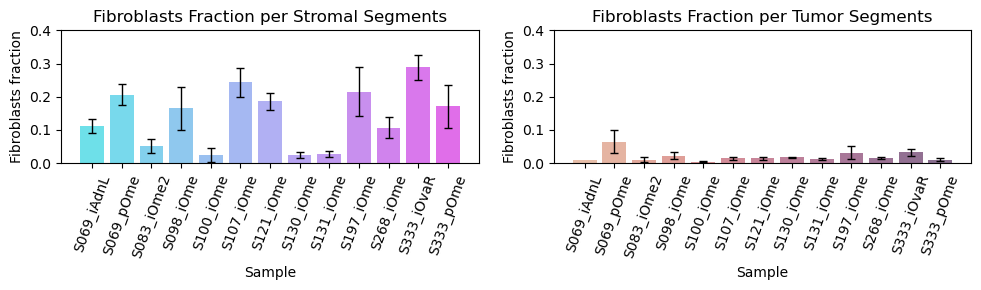

In [23]:

fig,(ax2,ax3)=plt.subplots(1,2,figsize=(10, 3))


sns.barplot(x="Sample", y="mean", data=stromal_stats_sample_fibr,palette="cool",alpha=0.7,ax=ax2)
ax2.errorbar(
    x=np.arange(len(stromal_stats_sample_fibr)),
    y=stromal_stats_sample_fibr["mean"],
    yerr=stromal_stats_sample_fibr["ci95"],
    fmt='none',
    ecolor='black',
    capsize=3,
    linewidth=1.0
)
ax2.set_ylim(0, 0.4)
#ax2.set_xlabel("Sample")
ax2.set_ylabel("Fibroblasts fraction")
ax2.set_title("Fibroblasts Fraction per Stromal Segments")

ax2.set_xticks(np.arange(len(stromal_stats_sample_fibr)))
ax2.set_xticklabels(stromal_stats_sample_fibr["Sample"], rotation=70)

sns.barplot(x="Sample", y="mean", data=tumor_stats_sample_fibr,palette="flare",alpha=0.7,ax=ax3)
ax3.errorbar(
    x=np.arange(len(tumor_stats_sample_fibr)),
    y=tumor_stats_sample_fibr["mean"],
    yerr=tumor_stats_sample_fibr["ci95"],
    fmt='none',
    ecolor='black',
    capsize=3,
    linewidth=1.0
)
ax3.set_ylim(0, 0.4)
ax3.set_xlabel("Sample")
ax3.set_ylabel("Fibroblasts fraction")
ax3.set_title("Fibroblasts Fraction per Tumor Segments")

ax3.set_xticks(np.arange(len(tumor_stats_sample_fibr)))
ax3.set_xticklabels(tumor_stats_sample_fibr["Sample"], rotation=70)
plt.tight_layout()

Loading gene expression data and merging it with clinical data

In [25]:
gene_expression=pd.read_csv("filtered_data_transposed.csv")
geomx_metadata_modified = pd.read_csv("geomx_metadata_modified.csv")        # replace with your filename

# Select only the relevant columns from clinical data
clinical_subset = geomx_metadata_modified[["dcc_filename","Sample", "PFS_quartile", "OS_quartile", "BRCA_status", "HRP_status","Segment"]]
clinical_subset['dcc_filename'] = clinical_subset['dcc_filename'].str.replace('-', '.', regex=False)

#clinical_subset = clinical_subset.drop_duplicates(subset="Sample")
# Merge on the 'Sample' column
#merged_df = pd.merge(geomx_metadata, clinical_subset, on="Sample", how="left")

# Save the result
#merged_df.to_csv("geomx_with_clinical.csv", index=False)
#clinical_subset
gene_expression_modified = pd.merge(gene_expression, clinical_subset, on="dcc_filename", how="left")
gene_expression
gene_expression_modified.to_csv("filtered_data_transposed_modified.csv", index=False)
gene_expression_modified.head(20)


/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/4257539231.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_subset['dcc_filename'] = clinical_subset['dcc_filename'].str.replace('-', '.', regex=False)


Unnamed: 0                 dcc_filename     FGFR2      IL6R      CCR5  \
0            1  DSP.1001660016604.A.A02.dcc  3.361754  3.598443  2.308785   
1            2  DSP.1001660016604.A.A04.dcc  3.193818  3.509266  3.432931   
2            3  DSP.1001660016604.A.A05.dcc  3.592371  3.585760  2.789620   
3            4  DSP.1001660016604.A.A07.dcc  4.263898  3.448090  3.748175   
4            5  DSP.1001660016604.A.A08.dcc  3.592490  2.519654  3.733214   
5            6  DSP.1001660016604.A.A09.dcc  4.016844  3.262927  3.371962   
6            7  DSP.1001660016604.A.B01.dcc  3.563630  3.467260  2.559535   
7            8  DSP.1001660016604.A.B02.dcc  4.059072  3.717685  2.932056   
8            9  DSP.1001660016604.A.B06.dcc  3.799664  2.768309  2.242682   
9           10  DSP.1001660016604.A.B07.dcc  3.987423  3.727761  3.559503   
10          11  DSP.1001660016604.A.B08.dcc  2.241792  3.908556  3.406252   
11          12  DSP.1001660016604.A.B09.dcc  3.756582  3.183663  3.193181   
12          13  DSP.1001660016604.A.B10.dcc  3.354131  2.198092  2.929694   
13          14  DSP.1001660016604.A.B11.dcc  3.665688  2.685735  2.340044   
14          15  DSP.1001660016604.A.B12.dcc  3.491124  2.575293  3.028523   
15          16  DSP.1001660016604.A.C01.dcc  4.004233  3.537620  3.429267   
16          17  DSP.1001660016604.A.C02.dcc  3.561473  2.369484  3.175559   
17          18  DSP.1001660016604.A.C03.dcc  3.130916  3.214584  2.297819   
18          19  DSP.1001660016604.A.C04.dcc  3.956121  3.131274  3.271022   
19          20  DSP.1001660016604.A.C05.dcc  3.672652  3.070350  3.097659   

         HGF    IL10RB     TGFB1    TGFBR2      CCR2  ...     CXCL8       IL6  \
0   4.284057  2.643606  3.782934  4.211304  3.490294  ...  3.481467  2.998769   
1   3.656575  4.222768  5.312708  4.060718  3.310616  ...  2.659595  3.625401   
2   3.923520  2.913399  3.859592  4.513373  3.488150  ...  3.016881  3.000984   
3   4.267320  3.580283  4.988758  4.244939  3.792199  ...  4.046040  3.034237   
4   4.342483  3.709352  4.899960  3.900900  2.715060  ...  3.563410  3.661552   
5   3.820901  3.496185  4.124346  3.917691  4.091774  ...  3.648069  2.368962   
6   3.960309  3.680492  4.472503  4.591287  3.201860  ...  3.446904  3.314957   
7   4.409065  3.008124  4.976537  4.303537  3.929709  ...  3.878316  4.192371   
8   4.361210  3.367806  5.059482  4.108074  4.078876  ...  2.812949  2.966410   
9   3.739972  2.425620  3.752964  4.078315  3.457067  ...  3.572654  2.699637   
10  3.731643  3.578115  5.401966  5.146095  3.991879  ...  3.040394  2.980749   
11  4.610024  3.737978  4.312370  4.064992  3.508968  ...  3.518420  3.467273   
12  4.090480  3.353427  5.050636  4.988692  3.464952  ...  3.506990  2.504191   
13  2.388016  2.954209  4.347857  5.043341  2.383314  ...  1.781666  2.491777   
14  4.606004  3.790250  5.779462  4.744325  3.271007  ...  3.769769  2.914480   
15  3.738234  3.601131  4.491226  4.583212  4.046288  ...  3.635595  3.960014   
16  3.733852  2.651641  5.175768  4.299452  2.917724  ...  4.029164  2.750056   
17  3.913754  3.613083  4.786806  4.199669  1.913534  ...  1.757925  2.113837   
18  4.017324  3.442885  5.524387  4.264531  2.055335  ...  3.303131  3.394179   
19  3.889580  3.789513  5.219727  3.343600  3.452487  ...  2.536555  2.784712   

       CXCR1     FGF10     Sample  PFS_quartile  OS_quartile  BRCA_status  \
0   5.090631  3.105129  S130_iOme             1            1          0.0   
1   4.707195  3.724372  S130_iOme             1            1          0.0   
2   4.117627  3.778433  S130_iOme             1            1          0.0   
3   4.881722  4.301300  S130_iOme             1            1          0.0   
4   3.364460  3.932246  S130_iOme             1            1          0.0   
5   3.826462  3.937070  S130_iOme             1            1          0.0   
6   4.036185  3.245078  S130_iOme             1            1          0.0   
7   4.758217  4.307614  S130_iOme             1            1        

In [26]:
clinical_subset['dcc_filename'] = clinical_subset['dcc_filename'].str.replace('-', '.', regex=False)

# Check the updated dataframe
print(clinical_subset['dcc_filename'].head())


0    DSP.1001660016604.A.A02.dcc
1    DSP.1001660016604.A.A04.dcc
2    DSP.1001660016604.A.A05.dcc
3    DSP.1001660016604.A.A07.dcc
4    DSP.1001660016604.A.A08.dcc
Name: dcc_filename, dtype: object


/var/folders/5f/jg_zhw0n3xl1tf79w0wk705r0000gn/T/ipykernel_12369/3007355666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_subset['dcc_filename'] = clinical_subset['dcc_filename'].str.replace('-', '.', regex=False)


Identifying genes of interest and plotting heatmaps with normalised gene of interest expression in tumor and stromal segments

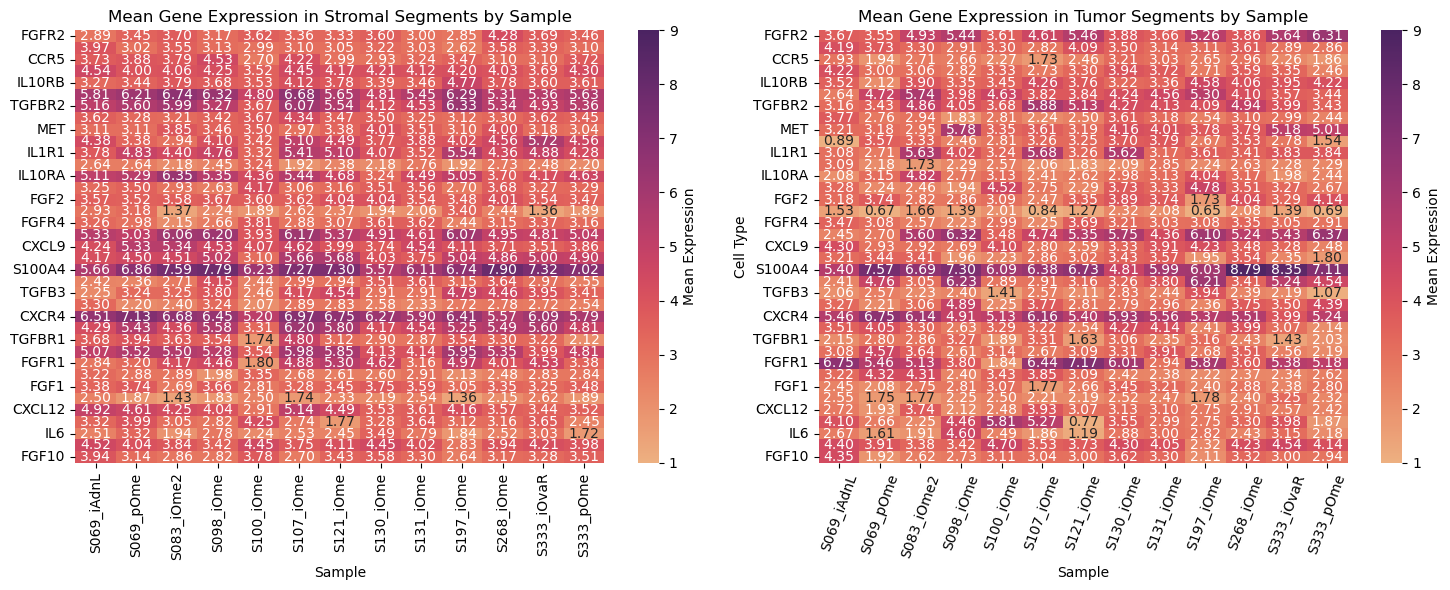

In [27]:
stromal_gene_exp = gene_expression_modified[gene_expression_modified["Segment"] == "stroma"]
tumor_gene_exp = gene_expression_modified[gene_expression_modified["Segment"] == "tumor"]

genes_of_interest = ['FGFR2', 'IL6R', 'CCR5', 'HGF', 'IL10RB',
       'TGFB1', 'TGFBR2', 'CCR2', 'MET', 'LRRC15', 'IL1R1', 'CXCR2', 'IL10RA',
       'CXCL10', 'FGF2', 'FGF7', 'FGFR4', 'IL6ST', 'CXCL9', 'PDGFRB', 'S100A4',
       'TGFB2', 'TGFB3', 'TGFBR3', 'CXCR4', 'FAP', 'TGFBR1', 'PDGFRA', 'FGFR1',
       'FGFR3', 'FGF1', 'IL1R2', 'CXCL12', 'CXCL8', 'IL6', 'CXCR1', 'FGF10']


stromal_genes_heatmap = stromal_gene_exp.groupby("Sample")[genes_of_interest].mean().T
tumor_genes_heatmap = tumor_gene_exp.groupby("Sample")[genes_of_interest].mean().T

fig, (axes1,axes2) = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(stromal_genes_heatmap, cmap="flare", annot=True, fmt=".2f", vmin=1,vmax=9,cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in Stromal Segments by Sample")

sns.heatmap(tumor_genes_heatmap, cmap="flare", annot=True, fmt=".2f",vmin=1,vmax=9, cbar_kws={'label': 'Mean Expression'}, ax=axes2)
axes2.set_title("Mean Gene Expression in Tumor Segments by Sample")
plt.title("Mean Gene Expression in Tumor Segments by Sample")
plt.xlabel("Sample")
plt.xticks(rotation=70)
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mean Gene Expression in Stromal Segments by Sample')

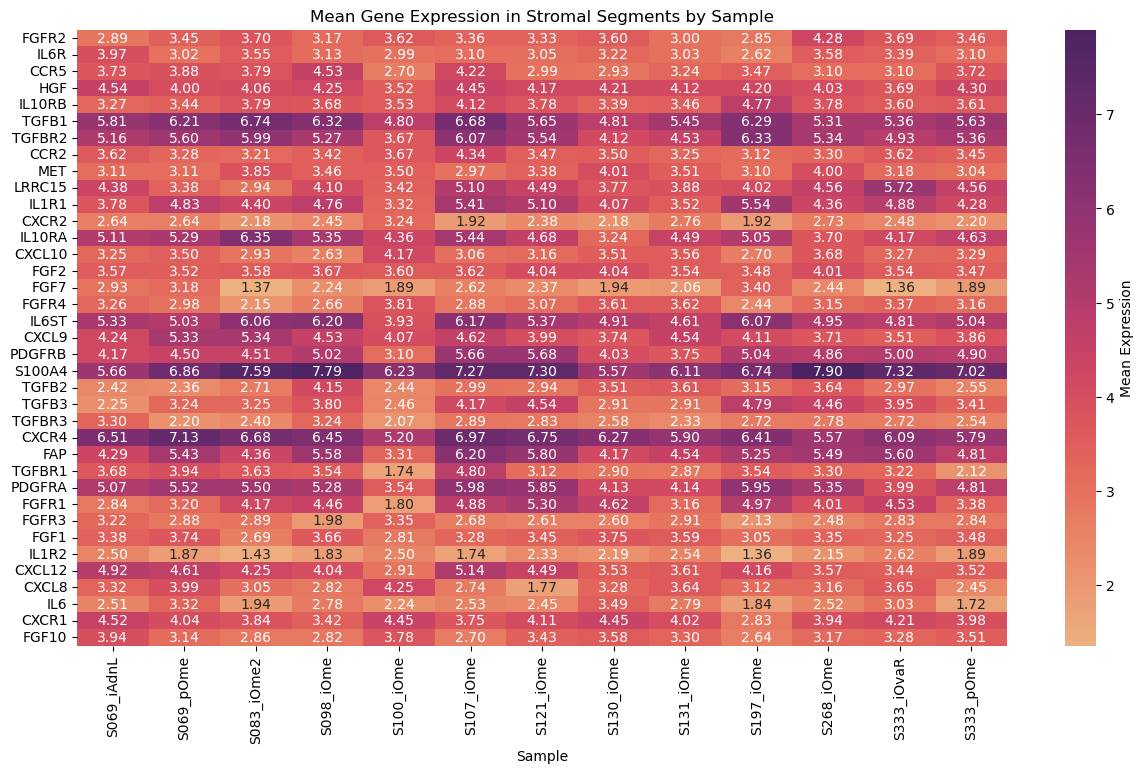

In [38]:
stromal_gene_exp = gene_expression_modified[gene_expression_modified["Segment"] == "stroma"]
tumor_gene_exp = gene_expression_modified[gene_expression_modified["Segment"] == "tumor"]

genes_of_interest = ['FGFR2', 'IL6R', 'CCR5', 'HGF', 'IL10RB',
       'TGFB1', 'TGFBR2', 'CCR2', 'MET', 'LRRC15', 'IL1R1', 'CXCR2', 'IL10RA',
       'CXCL10', 'FGF2', 'FGF7', 'FGFR4', 'IL6ST', 'CXCL9', 'PDGFRB', 'S100A4',
       'TGFB2', 'TGFB3', 'TGFBR3', 'CXCR4', 'FAP', 'TGFBR1', 'PDGFRA', 'FGFR1',
       'FGFR3', 'FGF1', 'IL1R2', 'CXCL12', 'CXCL8', 'IL6', 'CXCR1', 'FGF10']


stromal_genes_heatmap = stromal_gene_exp.groupby("Sample")[genes_of_interest].mean().T
tumor_genes_heatmap = tumor_gene_exp.groupby("Sample")[genes_of_interest].mean().T

fig, (axes1) = plt.subplots(1, 1, figsize=(15, 8))
sns.heatmap(stromal_genes_heatmap, cmap="flare", annot=True, fmt=".2f", cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in Stromal Segments by Sample")


Text(0.5, 1.0, 'Mean Gene Expression in Tumor Segments by Sample')

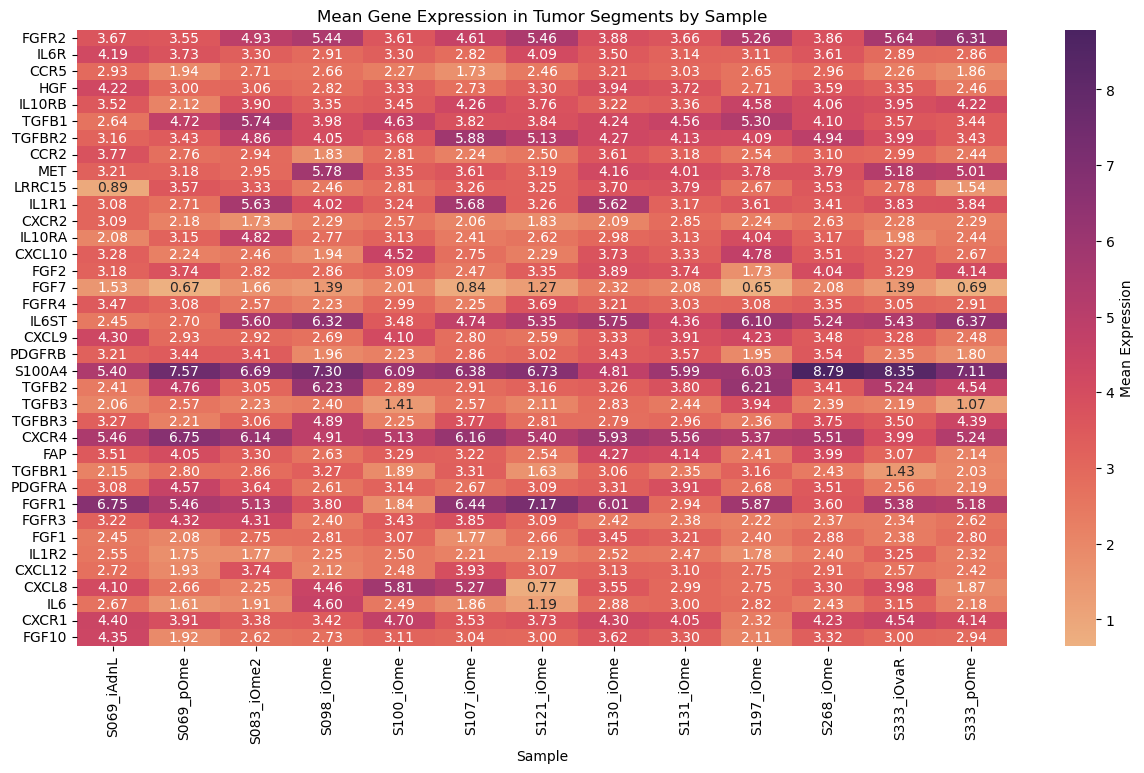

In [39]:

genes_of_interest = ['FGFR2', 'IL6R', 'CCR5', 'HGF', 'IL10RB',
       'TGFB1', 'TGFBR2', 'CCR2', 'MET', 'LRRC15', 'IL1R1', 'CXCR2', 'IL10RA',
       'CXCL10', 'FGF2', 'FGF7', 'FGFR4', 'IL6ST', 'CXCL9', 'PDGFRB', 'S100A4',
       'TGFB2', 'TGFB3', 'TGFBR3', 'CXCR4', 'FAP', 'TGFBR1', 'PDGFRA', 'FGFR1',
       'FGFR3', 'FGF1', 'IL1R2', 'CXCL12', 'CXCL8', 'IL6', 'CXCR1', 'FGF10']


fig, (axes1) = plt.subplots(1, 1, figsize=(15, 8))
sns.heatmap(tumor_genes_heatmap, cmap="flare", annot=True, fmt=".2f", cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in Tumor Segments by Sample")

Heatmap of normalized gene expression in all segments by sample

Text(0.5, 1.0, 'Mean Gene Expression in All Segments by Sample')

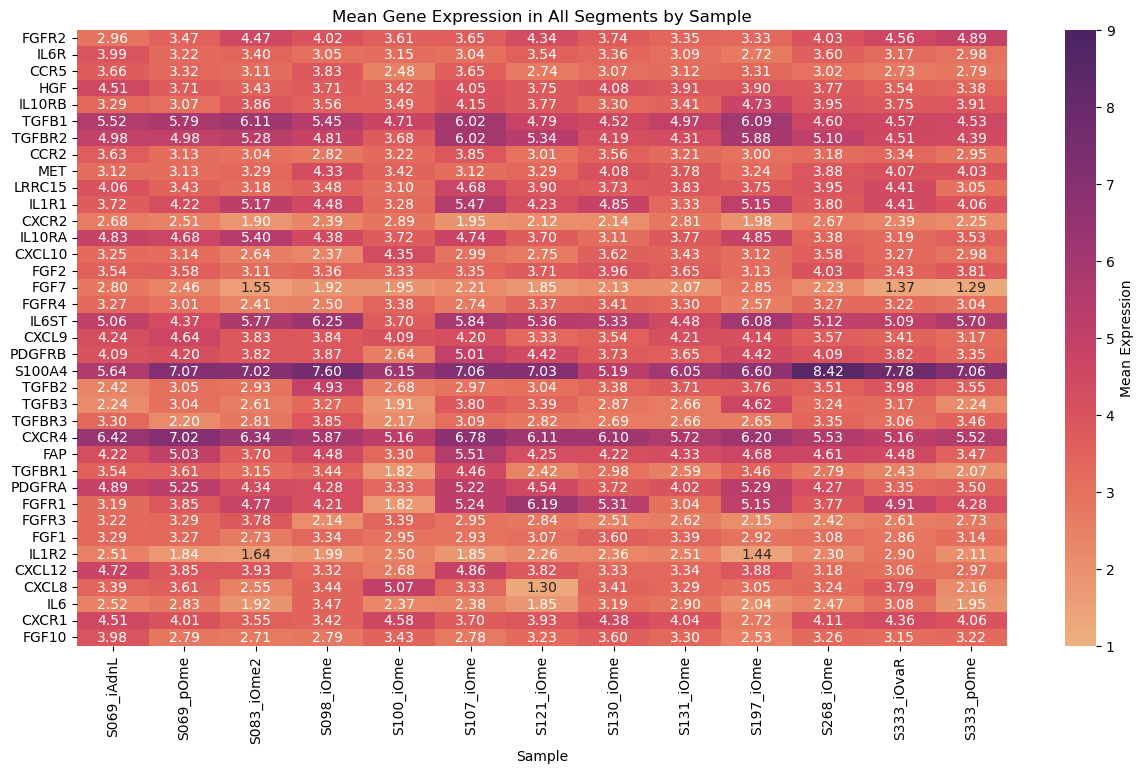

In [28]:
genes_of_interest = ['FGFR2', 'IL6R', 'CCR5', 'HGF', 'IL10RB',
       'TGFB1', 'TGFBR2', 'CCR2', 'MET', 'LRRC15', 'IL1R1', 'CXCR2', 'IL10RA',
       'CXCL10', 'FGF2', 'FGF7', 'FGFR4', 'IL6ST', 'CXCL9', 'PDGFRB', 'S100A4',
       'TGFB2', 'TGFB3', 'TGFBR3', 'CXCR4', 'FAP', 'TGFBR1', 'PDGFRA', 'FGFR1',
       'FGFR3', 'FGF1', 'IL1R2', 'CXCL12', 'CXCL8', 'IL6', 'CXCR1', 'FGF10']
all_genes_heatmap = gene_expression_modified.groupby("Sample")[genes_of_interest].mean().T
fig, (axes1) = plt.subplots(1, 1, figsize=(15, 8))
sns.heatmap(all_genes_heatmap, cmap="flare", annot=True, fmt=".2f", vmin=1,vmax=9,cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in All Segments by Sample")

In [29]:
target_CAF=["FAP","PDGFR","HH","FSP1","LRRC15","IL1R"]


cafs_factors_receptors= ["TGFb", "TGFbR", "IL6", "IL6R", "IL10R", "IL11", "CXCL8", "CXCL12", 
 "CCR2_5", "CXCR2", "CXCR1_2", "CXCR4", "CXCL9_10", "HGF", "cMET", 
 "FGF", "FGFR", "HA"]




genes_of_interest = ['FGFR2', 'IL6R', 'CCR5', 'HGF', 'IL10RB',
       'TGFB1', 'TGFBR2', 'CCR2', 'MET', 'LRRC15', 'IL1R1', 'CXCR2', 'IL10RA',
       'CXCL10', 'FGF2', 'FGF7', 'FGFR4', 'IL6ST', 'CXCL9', 'PDGFRB', 'S100A4',
       'TGFB2', 'TGFB3', 'TGFBR3', 'CXCR4', 'FAP', 'TGFBR1', 'PDGFRA', 'FGFR1',
       'FGFR3', 'FGF1', 'IL1R2', 'CXCL12', 'CXCL8', 'IL6', 'CXCR1', 'FGF10']




Heatmaps of CAF targets gene expression by sample in stromal and tumor segments

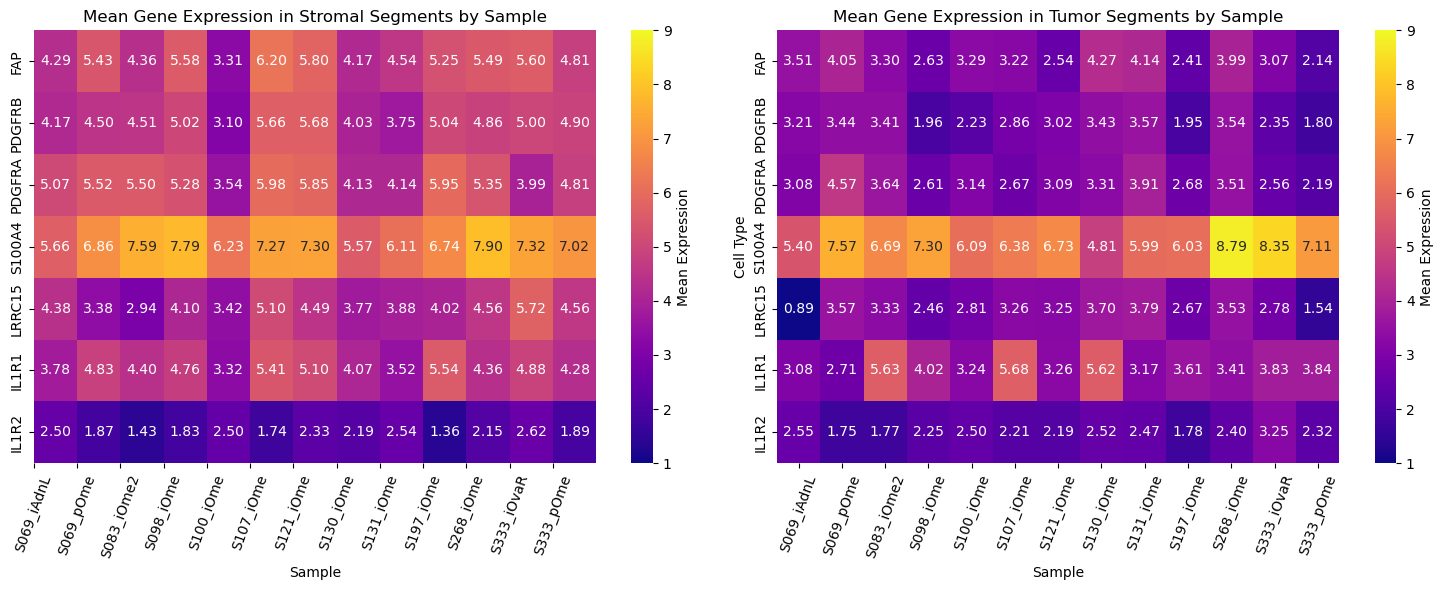

In [30]:
genes_of_interest_target=["FAP","PDGFRB",'PDGFRA', 'S100A4', "LRRC15","IL1R1","IL1R2"]

stromal_genes_heatmap_target = stromal_gene_exp.groupby("Sample")[genes_of_interest_target].mean().T
tumor_genes_heatmap_target = tumor_gene_exp.groupby("Sample")[genes_of_interest_target].mean().T

fig, (axes1,axes2) = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(stromal_genes_heatmap_target, cmap="plasma", annot=True, fmt=".2f",vmin=1,vmax=9, cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in Stromal Segments by Sample")
axes1.set_xticks(np.arange(len(tumor_stats_sample_fibr)))
axes1.set_xticklabels(tumor_genes_heatmap_target.T.index, rotation=70)

sns.heatmap(tumor_genes_heatmap_target, cmap="plasma", annot=True, fmt=".2f", vmin=1,vmax=9,cbar_kws={'label': 'Mean Expression'}, ax=axes2)
axes2.set_title("Mean Gene Expression in Tumor Segments by Sample")
#plt.title("Mean Cell Type Proportions in Stromal AOIs by Sample")
plt.xlabel("Sample")
plt.xticks(rotation=70)
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

Heatmaps of CAF targets gene expression by sample in all segments

Text(0.5, 1.0, 'Mean Gene Expression in All Segments by Sample')

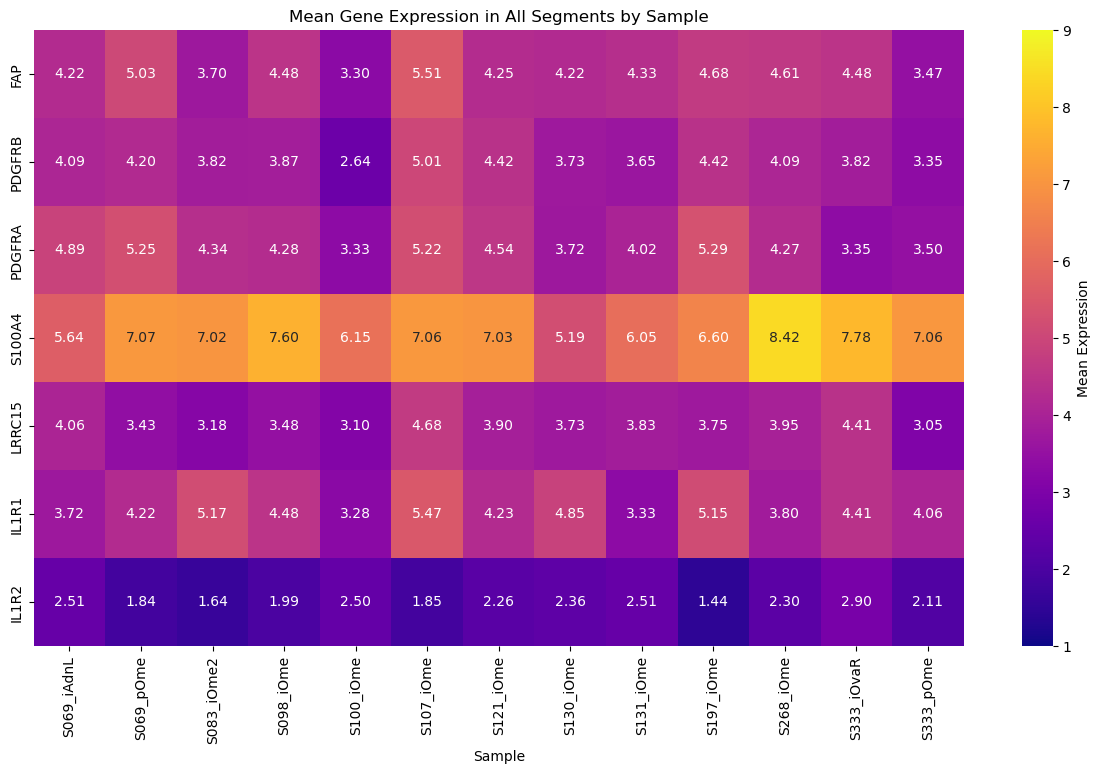

In [31]:

all_genes_heatmap = gene_expression_modified.groupby("Sample")[genes_of_interest_target].mean().T
fig, (axes1) = plt.subplots(1, 1, figsize=(15, 8))
sns.heatmap(all_genes_heatmap, cmap="plasma", annot=True, fmt=".2f",vmin=1,vmax=9, cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in All Segments by Sample")

Heatmaps of CAF derived markers/receptors gene expression by sample in stromal and tumor segments

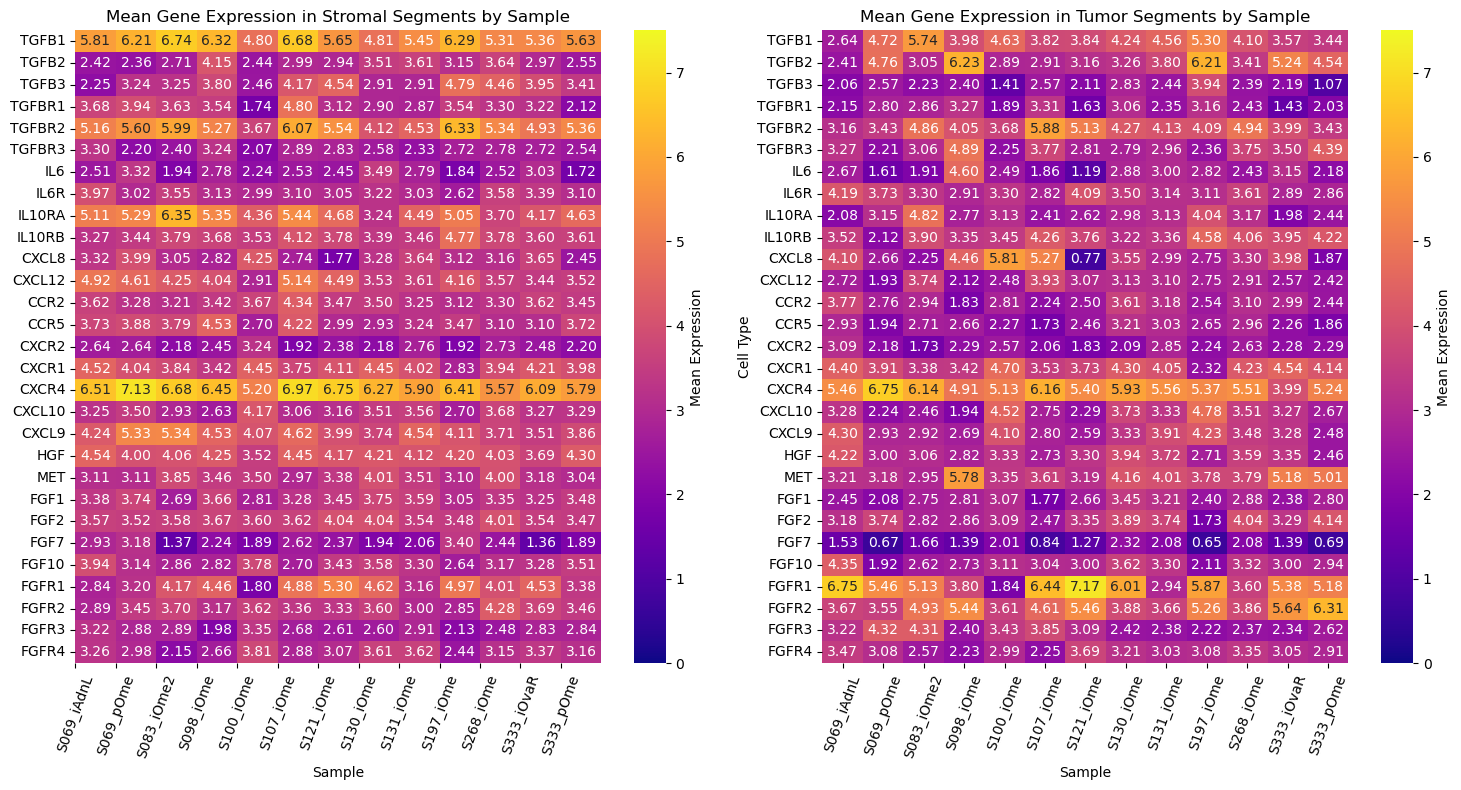

In [32]:
cafs_factors_receptors= ["TGFB1","TGFB2","TGFB3", "TGFBR1","TGFBR2","TGFBR3","IL6", "IL6R", "IL10RA","IL10RB", "CXCL8", "CXCL12", 
 "CCR2","CCR5", "CXCR2", "CXCR1", "CXCR4", "CXCL10","CXCL9","HGF", "MET", 
 "FGF1","FGF2","FGF7","FGF10", "FGFR1","FGFR2","FGFR3","FGFR4"]


stromal_genes_heatmap_factors_receptors = stromal_gene_exp.groupby("Sample")[cafs_factors_receptors].mean().T
tumor_genes_heatmap_factors_receptors = tumor_gene_exp.groupby("Sample")[cafs_factors_receptors].mean().T

fig, (axes1,axes2) = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(stromal_genes_heatmap_factors_receptors, cmap="plasma", annot=True, fmt=".2f",vmin=0,vmax=7.5, cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in Stromal Segments by Sample")
axes1.set_xticks(np.arange(len(tumor_stats_sample_fibr)))
axes1.set_xticklabels(tumor_genes_heatmap_factors_receptors.T.index, rotation=70)

sns.heatmap(tumor_genes_heatmap_factors_receptors, cmap="plasma", annot=True, fmt=".2f", vmin=0,vmax=7.5,cbar_kws={'label': 'Mean Expression'}, ax=axes2)
axes2.set_title("Mean Gene Expression in Tumor Segments by Sample")
#plt.title("Mean Cell Type Proportions in Stromal AOIs by Sample")
plt.xlabel("Sample")
plt.xticks(rotation=70)
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

Heatmaps of CAF derived markers/receptors gene expression by sample in all segments

Text(0.5, 1.0, 'Mean Gene Expression in All Segments by Sample')

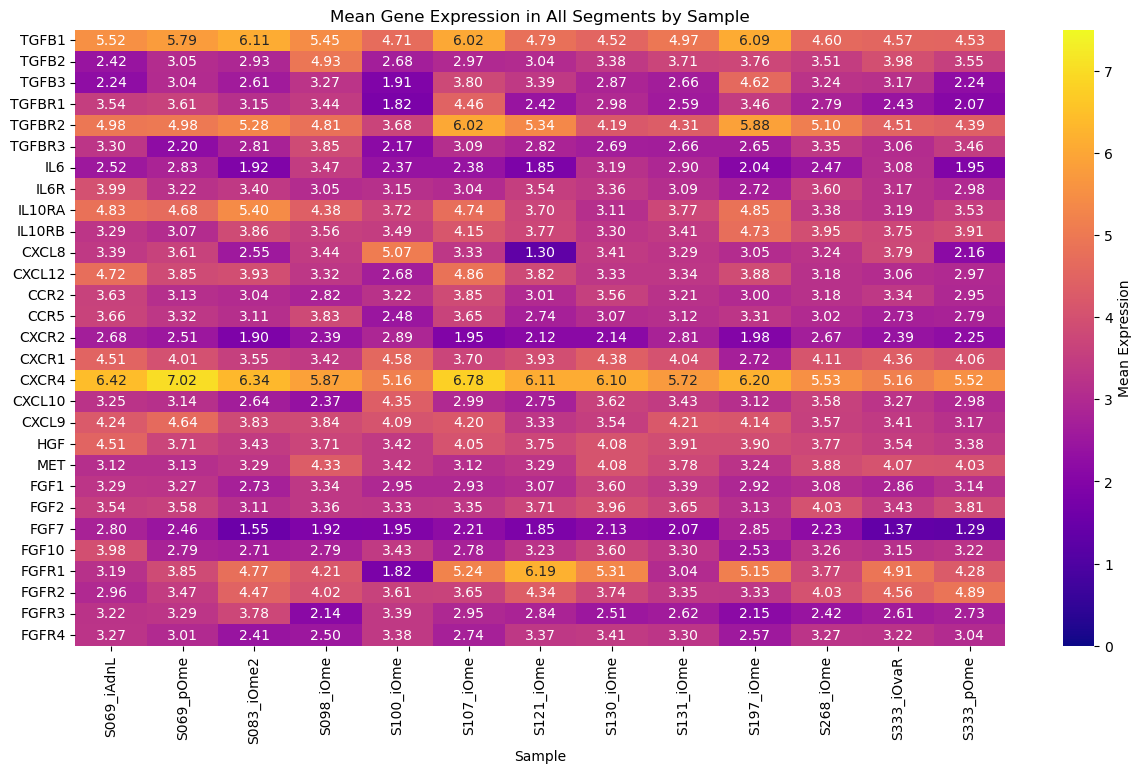

In [33]:
all_genes_heatmap = gene_expression_modified.groupby("Sample")[cafs_factors_receptors].mean().T
fig, (axes1) = plt.subplots(1, 1, figsize=(15, 8))
sns.heatmap(all_genes_heatmap, cmap="plasma", annot=True, fmt=".2f",vmin=0,vmax=7.5, cbar_kws={'label': 'Mean Expression'}, ax=axes1)
axes1.set_title("Mean Gene Expression in All Segments by Sample")

In [ ]:

df_tcell_abundance = pd.read_csv("bp_res_mid_lvl_ct_ct_fraction.csv")
df_tcell_abundance = df_tcell_abundance[["dcc_filename","Sample","Tcells","Segment"]]
df_gene_expression=gene_expression_modified
df_gene_expression


Unnamed: 0                 dcc_filename     FGFR2      IL6R      CCR5  \
0             1  DSP.1001660016604.A.A02.dcc  3.361754  3.598443  2.308785   
1             2  DSP.1001660016604.A.A04.dcc  3.193818  3.509266  3.432931   
2             3  DSP.1001660016604.A.A05.dcc  3.592371  3.585760  2.789620   
3             4  DSP.1001660016604.A.A07.dcc  4.263898  3.448090  3.748175   
4             5  DSP.1001660016604.A.A08.dcc  3.592490  2.519654  3.733214   
..          ...                          ...       ...       ...       ...   
189         190  DSP.1001660037247.C.D02.dcc  4.277910  2.770738  4.309911   
190         191  DSP.1001660037247.C.D03.dcc  7.289014  4.329459  3.163609   
191         192  DSP.1001660037247.C.D04.dcc  5.696289  1.054717  3.352850   
192         193  DSP.1001660037247.C.D05.dcc  7.233920  2.047122  0.548447   
193         194  DSP.1001660037247.C.D06.dcc  2.605100  3.975593  4.458266   

          HGF    IL10RB     TGFB1    TGFBR2      CCR2  ...     CXCL8  \
0    4.284057  2.643606  3.782934  4.211304  3.490294  ...  3.481467   
1    3.656575  4.222768  5.312708  4.060718  3.310616  ...  2.659595   
2    3.923520  2.913399  3.859592  4.513373  3.488150  ...  3.016881   
3    4.267320  3.580283  4.988758  4.244939  3.792199  ...  4.046040   
4    4.342483  3.709352  4.899960  3.900900  2.715060  ...  3.563410   
..        ...       ...       ...       ...       ...  ...       ...   
189  3.393038  3.972500  6.334667  5.911482  3.924523  ...  2.396354   
190  0.981959  4.264143  4.114525  3.345048  2.597749  ...  0.508454   
191  4.825368  4.988569  5.632562  5.853667  3.906748  ...  0.288400   
192  3.290937  4.166872  3.025344  3.246448  1.385948  ...  2.054575   
193  3.543807  3.149536  5.930979  5.726414  3.845015  ...  2.147237   

          IL6     CXCR1     FGF10     Sample  PFS_quartile  OS_quartile  \
0    2.998769  5.090631  3.105129  S130_iOme             1            1   
1    3.625401  4.707195  3.724372  S130_iOme             1            1   
2    3.000984  4.117627  3.778433  S130_iOme             1            1   
3    3.034237  4.881722  4.301300  S130_iOme             1            1   
4    3.661552  3.364460  3.932246  S130_iOme             1            1   
..        ...       ...       ...        ...           ...          ...   
189  2.047406  3.869936  3.404106  S333_pOme             3            1   
190  2.845793  3.992833  1.837595  S333_pOme             3            1   
191  0.331385  2.796994  3.337978  S333_pOme             3            1   
192  1.725636  4.064308  2.462543  S333_pOme             3            1   
193  0.313732  3.325268  3.276580  S333_pOme             3            1   

     BRCA_status  HRP_status  Segment  
0            0.0         1.0   stroma  
1            0.0         1.0   stroma  
2            0.0         1.0    tumor  
3            0.0         1.0    tumor  
4            0.0         1.0   stroma  
..           ...         ...      ...  
189          0.0         1.0   stroma  
190          0.0         1.0    tumor  
191          0.0         1.0   stroma  
192          0.0         1.0    tumor  
193          0.0         1.0   stroma  

[194 rows x 45 columns]

Averaging CAF targets genes of interest expression in each sample

In [35]:
genes_of_interest_target=["FAP","PDGFRB",'PDGFRA', 'S100A4', "LRRC15","IL1R1","IL1R2"]

all_genes_heatmap = gene_expression_modified.groupby("Sample")[genes_of_interest_target].mean()
all_genes_heatmap

FAP    PDGFRB    PDGFRA    S100A4    LRRC15     IL1R1  \
Sample                                                                   
S069_iAdnL  4.223893  4.085527  4.893310  5.636995  4.059797  3.717772   
S069_pOme   5.032948  4.195162  5.246382  7.065359  3.433204  4.222625   
S083_iOme2  3.696862  3.824087  4.338489  7.024784  3.182031  5.167721   
S098_iOme   4.475257  3.871480  4.279535  7.604827  3.484942  4.481441   
S100_iOme   3.301103  2.642826  3.330096  6.154019  3.101335  3.278386   
S107_iOme   5.510907  5.014539  5.216704  7.063174  4.676095  5.469389   
S121_iOme   4.253073  4.420027  4.541094  7.030810  3.902928  4.232556   
S130_iOme   4.215409  3.728741  3.718031  5.187518  3.730858  4.847157   
S131_iOme   4.330816  3.651524  4.019406  6.045837  3.832483  3.332962   
S197_iOme   4.681996  4.423394  5.294594  6.596790  3.749077  5.151223   
S268_iOme   4.609610  4.087414  4.267179  8.422550  3.952174  3.799615   
S333_iOvaR  4.480216  3.820787  3.351175  7.778266  4.413894  4.413545   
S333_pOme   3.470356  3.350582  3.499722  7.061087  3.049921  4.060232   

               IL1R2  
Sample                
S069_iAdnL  2.506176  
S069_pOme   1.838183  
S083_iOme2  1.641856  
S098_iOme   1.991464  
S100_iOme   2.497262  
S107_iOme   1.849498  
S121_iOme   2.261643  
S130_iOme   2.356541  
S131_iOme   2.505878  
S197_iOme   1.440305  
S268_iOme   2.299743  
S333_iOvaR  2.898777  
S333_pOme   2.105357

Computing mean of T cells proportion in all segments in each sample

In [36]:
df_tcell_abundance_mean=df_tcell_abundance.groupby("Sample")["Tcells"].mean()
df_tcell_abundance_mean

Sample
S069_iAdnL    0.044274
S069_pOme     0.040369
S083_iOme2    0.039678
S098_iOme     0.028081
S100_iOme     0.043375
S107_iOme     0.020550
S121_iOme     0.024507
S130_iOme     0.047881
S131_iOme     0.050019
S197_iOme     0.030785
S268_iOme     0.045362
S333_iOvaR    0.025758
S333_pOme     0.029830
Name: Tcells, dtype: float64

Merging the dataframes with T cell abundance per sample and gene expression

In [37]:
merged_df_tcell=pd.merge(df_tcell_abundance_mean, all_genes_heatmap, on="Sample", how="left")
merged_df_tcell["Sample"]=merged_df_tcell.index

Tcells       FAP    PDGFRB    PDGFRA    S100A4    LRRC15  \
Sample                                                                   
S069_iAdnL  0.044274  4.223893  4.085527  4.893310  5.636995  4.059797   
S069_pOme   0.040369  5.032948  4.195162  5.246382  7.065359  3.433204   
S083_iOme2  0.039678  3.696862  3.824087  4.338489  7.024784  3.182031   
S098_iOme   0.028081  4.475257  3.871480  4.279535  7.604827  3.484942   
S100_iOme   0.043375  3.301103  2.642826  3.330096  6.154019  3.101335   
S107_iOme   0.020550  5.510907  5.014539  5.216704  7.063174  4.676095   
S121_iOme   0.024507  4.253073  4.420027  4.541094  7.030810  3.902928   
S130_iOme   0.047881  4.215409  3.728741  3.718031  5.187518  3.730858   
S131_iOme   0.050019  4.330816  3.651524  4.019406  6.045837  3.832483   
S197_iOme   0.030785  4.681996  4.423394  5.294594  6.596790  3.749077   
S268_iOme   0.045362  4.609610  4.087414  4.267179  8.422550  3.952174   
S333_iOvaR  0.025758  4.480216  3.820787  3.351175  7.778266  4.413894   
S333_pOme   0.029830  3.470356  3.350582  3.499722  7.061087  3.049921   

               IL1R1     IL1R2      Sample  
Sample                                      
S069_iAdnL  3.717772  2.506176  S069_iAdnL  
S069_pOme   4.222625  1.838183   S069_pOme  
S083_iOme2  5.167721  1.641856  S083_iOme2  
S098_iOme   4.481441  1.991464   S098_iOme  
S100_iOme   3.278386  2.497262   S100_iOme  
S107_iOme   5.469389  1.849498   S107_iOme  
S121_iOme   4.232556  2.261643   S121_iOme  
S130_iOme   4.847157  2.356541   S130_iOme  
S131_iOme   3.332962  2.505878   S131_iOme  
S197_iOme   5.151223  1.440305   S197_iOme  
S268_iOme   3.799615  2.299743   S268_iOme  
S333_iOvaR  4.413545  2.898777  S333_iOvaR  
S333_pOme   4.060232  2.105357   S333_pOme

Generating a heatmap showing the correlation of T cell abundance and CAF target mean gene expression , where bubble size corresponds to T cell proportion and color to CAF target gene expression

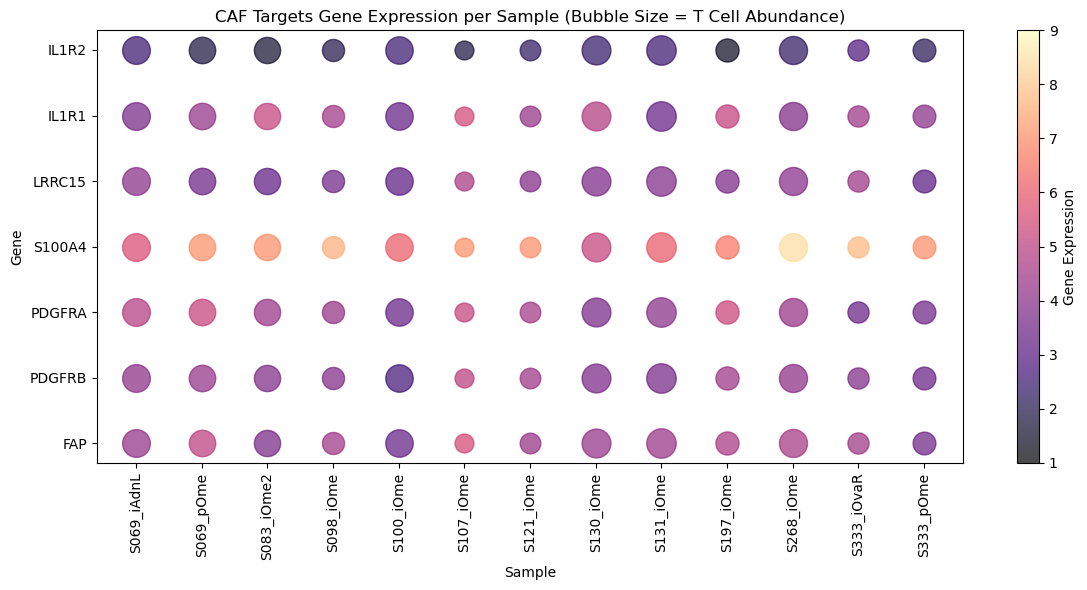

In [40]:

plt.figure(figsize=(12, 6))

# Get coordinates for x (samples) and y (genes)
x_vals = merged_df_tcell['Sample']
samples = merged_df_tcell['Sample'].unique()
genes = genes_of_interest_target

# Loop through genes to plot all combinations
for gene in genes:
    for i, sample in enumerate(samples):
        expression = merged_df_tcell.loc[merged_df_tcell['Sample'] == sample, gene].values[0]
        t_cells = merged_df_tcell.loc[merged_df_tcell['Sample'] == sample, 'Tcells'].values[0]
        
        plt.scatter(
            x=sample,
            y=gene,
            s=t_cells * 9000,  # scale bubble size as needed
            c=expression,
            cmap='magma',
            vmin=1,  # consistent color scale
            vmax=9,
            alpha=0.7
        )

plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Gene")
plt.title("CAF Targets Gene Expression per Sample (Bubble Size = T Cell Abundance)")
plt.colorbar(label="Gene Expression")
plt.tight_layout()
plt.show()


Generating a heatmap showing the correlation of T cell abundance and CAF target mean gene expression , where bubble size corresponds to T cell proportion and color to CAF derived markers/receptors gene expression

In [41]:
genes_of_interest_receptors_targets=["TGFB1","TGFB2","TGFB3", "TGFBR1","TGFBR2","TGFBR3","IL6", "IL6R", "IL10RA","IL10RB", "CXCL8", "CXCL12", 
 "CCR2","CCR5", "CXCR2", "CXCR1", "CXCR4", "CXCL10","CXCL9","HGF", "MET", 
 "FGF1","FGF2","FGF7","FGF10", "FGFR1","FGFR2","FGFR3","FGFR4"]

all_genes_receptors_heatmap = gene_expression_modified.groupby("Sample")[genes_of_interest_receptors_targets].mean()
all_genes_receptors_heatmap

TGFB1     TGFB2     TGFB3    TGFBR1    TGFBR2    TGFBR3  \
Sample                                                                   
S069_iAdnL  5.522421  2.416770  2.235699  3.537084  4.977820  3.301633   
S069_pOme   5.787911  3.048754  3.043983  3.612383  4.982083  2.199732   
S083_iOme2  6.110539  2.925212  2.614272  3.150677  5.284362  2.811960   
S098_iOme   5.445398  4.934141  3.274776  3.436178  4.814586  3.854465   
S100_iOme   4.714231  2.680263  1.905819  1.818020  3.676050  2.165059   
S107_iOme   6.018894  2.968606  3.802621  4.459790  6.023686  3.091368   
S121_iOme   4.791588  3.042153  3.385908  2.416826  5.344623  2.820028   
S130_iOme   4.522978  3.384900  2.869851  2.984713  4.193014  2.685914   
S131_iOme   4.974376  3.714775  2.659556  2.592165  4.313932  2.664804   
S197_iOme   6.090150  3.758955  4.616875  3.462304  5.884929  2.652633   
S268_iOme   4.600125  3.505679  3.244618  2.789971  5.103696  3.350621   
S333_iOvaR  4.565447  3.978669  3.168373  2.425646  4.510740  3.064315   
S333_pOme   4.532862  3.545551  2.236938  2.074916  4.393106  3.464132   

                 IL6      IL6R    IL10RA    IL10RB  ...       HGF       MET  \
Sample                                              ...                       
S069_iAdnL  2.523710  3.992582  4.832305  3.294423  ...  4.509133  3.116146   
S069_pOme   2.832166  3.218793  4.677356  3.065172  ...  3.712219  3.126266   
S083_iOme2  1.919547  3.395598  5.395707  3.860349  ...  3.434584  3.286532   
S098_iOme   3.466220  3.050802  4.381390  3.557042  ...  3.714188  4.330116   
S100_iOme   2.374774  3.151492  3.715654  3.488548  ...  3.421314  3.419263   
S107_iOme   2.376032  3.035910  4.737942  4.149377  ...  4.054105  3.116568   
S121_iOme   1.854957  3.544409  3.703470  3.773153  ...  3.754984  3.293679   
S130_iOme   3.186328  3.360516  3.111657  3.304763  ...  4.076541  4.083850   
S131_iOme   2.904641  3.089477  3.765284  3.407387  ...  3.906627  3.776274   
S197_iOme   2.038093  2.716775  4.851054  4.732292  ...  3.903987  3.236619   
S268_iOme   2.467595  3.595153  3.384526  3.947127  ...  3.773080  3.877790   
S333_iOvaR  3.084521  3.166815  3.193502  3.753057  ...  3.539447  4.069603   
S333_pOme   1.951272  2.980448  3.532834  3.914371  ...  3.379148  4.025349   

                FGF1      FGF2      FGF7     FGF10     FGFR1     FGFR2  \
Sample                                                                   
S069_iAdnL  3.293065  3.538972  2.799415  3.977873  3.192838  2.964540   
S069_pOme   3.266233  3.580984  2.460512  2.792079  3.847521  3.474181   
S083_iOme2  2.728729  3.108050  1.548615  2.705439  4.774229  4.469115   
S098_iOme   3.343363  3.363826  1.917877  2.787144  4.211487  4.023843   
S100_iOme   2.948520  3.329846  1.952358  3.426151  1.817324  3.613601   
S107_iOme   2.931565  3.353604  2.206067  2.776417  5.237371  3.652238   
S121_iOme   3.073845  3.712070  1.852954  3.227547  6.185091  4.338252   
S130_iOme   3.604700  3.964254  2.132105  3.603862  5.314083  3.743096   
S131_iOme   3.389486  3.646763  2.073300  3.301261  3.041053  3.350889   
S197_iOme   2.918531  3.132999  2.848370  2.531156  5.148489  3.330935   
S268_iOme   3.075340  4.027348  2.226389  3.256940  3.768984  4.033278   
S333_iOvaR  2.860783  3.428860  1.370639  3.154792  4.907738  4.557417   
S333_pOme   3.141789  3.808926  1.292788  3.224936  4.277095  4.885486   

               FGFR3     FGFR4  
Sample                          
S069_iAdnL  3.224065  3.274471  
S069_pOme   3.293641  3.011733  
S083_iOme2  3.778185  2.412683  
S098_iOme   2.135445  2.500106  
S100_iOme   3.393237  3.378814  
S107_iOme   2.947301  2.738752  
S121_iOme   2.835824  3.366592  
S130_iOme   2.510402  3.408855  
S131_iOme   2.624434  3.304836  
S197_iOme   2.148525  2.569627  
S268_iOme   2.417758  3.267079  
S333_iOvaR  2.612816  3.224854  
S333_pOme   2.728038  3.037206  

[13 rows x 29 columns]

In [42]:
merged_df_tcell_receptors=pd.merge(df_tcell_abundance_mean, all_genes_receptors_heatmap, on="Sample", how="left")
merged_df_tcell_receptors["Sample"]=merged_df_tcell_receptors.index
merged_df_tcell_receptors

Tcells     TGFB1     TGFB2     TGFB3    TGFBR1    TGFBR2  \
Sample                                                                   
S069_iAdnL  0.044274  5.522421  2.416770  2.235699  3.537084  4.977820   
S069_pOme   0.040369  5.787911  3.048754  3.043983  3.612383  4.982083   
S083_iOme2  0.039678  6.110539  2.925212  2.614272  3.150677  5.284362   
S098_iOme   0.028081  5.445398  4.934141  3.274776  3.436178  4.814586   
S100_iOme   0.043375  4.714231  2.680263  1.905819  1.818020  3.676050   
S107_iOme   0.020550  6.018894  2.968606  3.802621  4.459790  6.023686   
S121_iOme   0.024507  4.791588  3.042153  3.385908  2.416826  5.344623   
S130_iOme   0.047881  4.522978  3.384900  2.869851  2.984713  4.193014   
S131_iOme   0.050019  4.974376  3.714775  2.659556  2.592165  4.313932   
S197_iOme   0.030785  6.090150  3.758955  4.616875  3.462304  5.884929   
S268_iOme   0.045362  4.600125  3.505679  3.244618  2.789971  5.103696   
S333_iOvaR  0.025758  4.565447  3.978669  3.168373  2.425646  4.510740   
S333_pOme   0.029830  4.532862  3.545551  2.236938  2.074916  4.393106   

              TGFBR3       IL6      IL6R    IL10RA  ...       MET      FGF1  \
Sample                                              ...                       
S069_iAdnL  3.301633  2.523710  3.992582  4.832305  ...  3.116146  3.293065   
S069_pOme   2.199732  2.832166  3.218793  4.677356  ...  3.126266  3.266233   
S083_iOme2  2.811960  1.919547  3.395598  5.395707  ...  3.286532  2.728729   
S098_iOme   3.854465  3.466220  3.050802  4.381390  ...  4.330116  3.343363   
S100_iOme   2.165059  2.374774  3.151492  3.715654  ...  3.419263  2.948520   
S107_iOme   3.091368  2.376032  3.035910  4.737942  ...  3.116568  2.931565   
S121_iOme   2.820028  1.854957  3.544409  3.703470  ...  3.293679  3.073845   
S130_iOme   2.685914  3.186328  3.360516  3.111657  ...  4.083850  3.604700   
S131_iOme   2.664804  2.904641  3.089477  3.765284  ...  3.776274  3.389486   
S197_iOme   2.652633  2.038093  2.716775  4.851054  ...  3.236619  2.918531   
S268_iOme   3.350621  2.467595  3.595153  3.384526  ...  3.877790  3.075340   
S333_iOvaR  3.064315  3.084521  3.166815  3.193502  ...  4.069603  2.860783   
S333_pOme   3.464132  1.951272  2.980448  3.532834  ...  4.025349  3.141789   

                FGF2      FGF7     FGF10     FGFR1     FGFR2     FGFR3  \
Sample                                                                   
S069_iAdnL  3.538972  2.799415  3.977873  3.192838  2.964540  3.224065   
S069_pOme   3.580984  2.460512  2.792079  3.847521  3.474181  3.293641   
S083_iOme2  3.108050  1.548615  2.705439  4.774229  4.469115  3.778185   
S098_iOme   3.363826  1.917877  2.787144  4.211487  4.023843  2.135445   
S100_iOme   3.329846  1.952358  3.426151  1.817324  3.613601  3.393237   
S107_iOme   3.353604  2.206067  2.776417  5.237371  3.652238  2.947301   
S121_iOme   3.712070  1.852954  3.227547  6.185091  4.338252  2.835824   
S130_iOme   3.964254  2.132105  3.603862  5.314083  3.743096  2.510402   
S131_iOme   3.646763  2.073300  3.301261  3.041053  3.350889  2.624434   
S197_iOme   3.132999  2.848370  2.531156  5.148489  3.330935  2.148525   
S268_iOme   4.027348  2.226389  3.256940  3.768984  4.033278  2.417758   
S333_iOvaR  3.428860  1.370639  3.154792  4.907738  4.557417  2.612816   
S333_pOme   3.808926  1.292788  3.224936  4.277095  4.885486  2.728038   

               FGFR4      Sample  
Sample                            
S069_iAdnL  3.274471  S069_iAdnL  
S069_pOme   3.011733   S069_pOme  
S083_iOme2  2.412683  S083_iOme2  
S098_iOme   2.500106   S098_iOme  
S100_iOme   3.378814   S100_iOme  
S107_iOme   2.738752   S107_iOme  
S121_iOme   3.366592   S121_iOme  
S130_iOme   3.408855   S130_iOme  
S131_iOme   3.304836   S131_iOme  
S197_iOme   2.569627   S197_iOme  
S268_iOme   3.267079   S268_iOme  
S333_iOvaR  3.224854  S333_iOvaR  
S333_pOme   3.037206   S333_pOme  

[13 rows x 31 columns]

1.2927879414267662
7.024939623171262


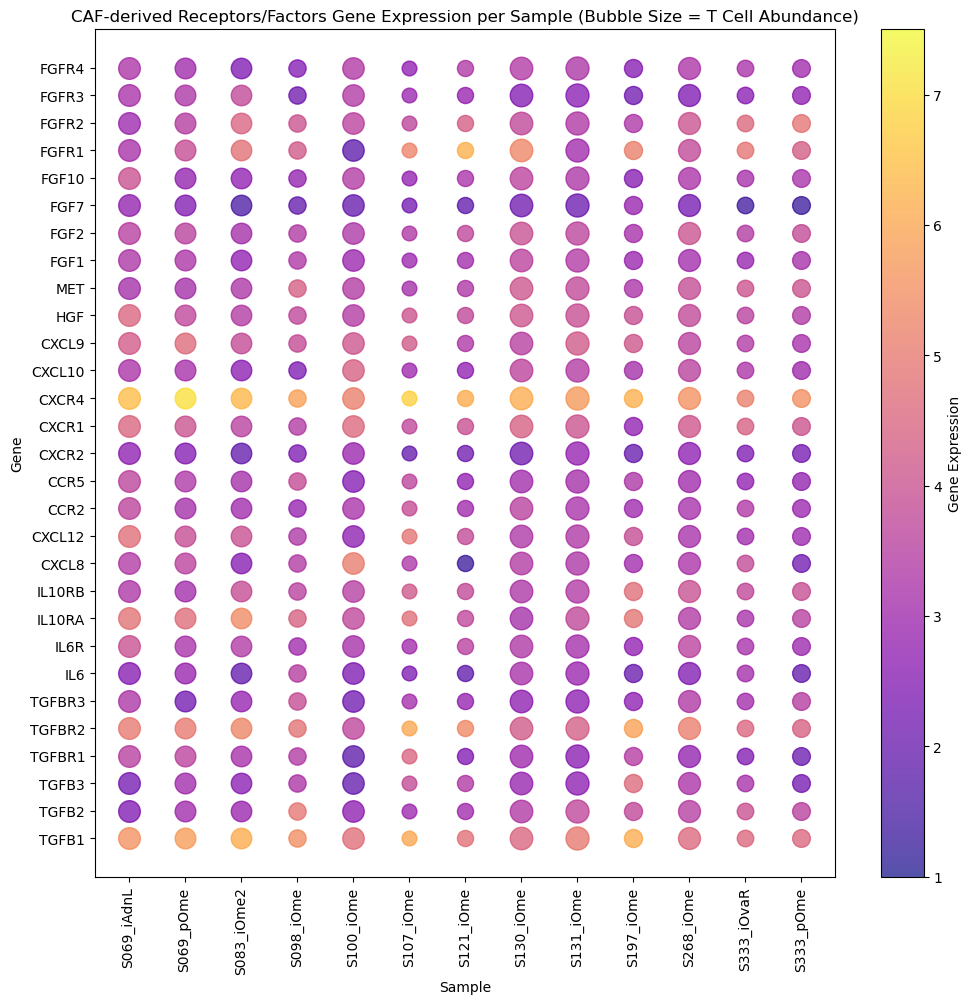

In [43]:

x_vals = merged_df_tcell_receptors['Sample']
samples = merged_df_tcell_receptors['Sample'].unique()
genes =genes_of_interest_receptors_targets

plt.figure(figsize=(len(samples)*0.8,len(genes)*0.35))
# Loop through genes to plot all combinations
vmina = []
vmaxa = []
for gene in genes:
    vmina.append(merged_df_tcell_receptors[gene].min())
    vmaxa.append(merged_df_tcell_receptors[gene].max())
    for i, sample in enumerate(samples):
        expression = merged_df_tcell_receptors.loc[merged_df_tcell_receptors['Sample'] == sample, gene].values[0]
        t_cells = merged_df_tcell_receptors.loc[merged_df_tcell_receptors['Sample'] == sample, 'Tcells'].values[0]
        
        plt.scatter(
            x=sample,
            y=gene,
            s=t_cells * 5500,  # scale bubble size as needed
            c=expression,
            cmap='plasma',
            vmin=1,  # consistent color scale
            vmax=7.5,
            alpha=0.7
        )
print(min(vmina))
print(max(vmaxa))
plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Gene")
plt.title("CAF-derived Receptors/Factors Gene Expression per Sample (Bubble Size = T Cell Abundance)")
plt.colorbar(label="Gene Expression")
plt.tight_layout()
plt.show()


In [57]:
aoi_segment= pd.read_csv("bp_res_mid_lvl_ct_ct_fraction.csv")[["dcc_filename","Segment"]]
df_tcell_abundance["Segment"]=aoi_segment["Segment"]

In [58]:
genes_of_interest_receptors_targets=["TGFB1","TGFB2","TGFB3", "TGFBR1","TGFBR2","TGFBR3","IL6", "IL6R", "IL10RA","IL10RB", "CXCL8", "CXCL12", 
 "CCR2","CCR5", "CXCR2", "CXCR1", "CXCR4", "CXCL10","CXCL9","HGF", "MET", 
 "FGF1","FGF2","FGF7","FGF10", "FGFR1","FGFR2","FGFR3","FGFR4"]

gene_expression_modified_tumor = gene_expression_modified[gene_expression_modified["Segment"] == "tumor"]

all_genes_heatmap_tumor = gene_expression_modified_tumor.groupby("Sample")[genes_of_interest_receptors_targets].mean()

df_tcell_abundance_tumor=df_tcell_abundance[df_tcell_abundance["Segment"] == "tumor"]

df_tcell_abundance_mean_tumor=df_tcell_abundance_tumor.groupby("Sample")["Tcells"].mean()
df_tcell_abundance_mean_tumor


merged_df_tcell_tumor_derived=pd.merge(df_tcell_abundance_mean_tumor, all_genes_heatmap_tumor, on="Sample", how="left")
merged_df_tcell_tumor_derived["Sample"]=merged_df_tcell_tumor_derived.index

In [50]:
merged_df_tcell_tumor_derived

Tcells       FAP    PDGFRB    PDGFRA    S100A4    LRRC15  \
Sample                                                                   
S069_iAdnL  0.045245  3.513568  3.212227  3.080769  5.399535  0.886367   
S069_pOme   0.047488  4.045502  3.436776  4.569866  7.568268  3.569169   
S083_iOme2  0.055305  3.300834  3.411964  3.638982  6.687852  3.327498   
S098_iOme   0.034437  2.632912  1.957721  2.606752  7.304229  2.460201   
S100_iOme   0.046503  3.292906  2.232019  3.139803  6.089843  2.813484   
S107_iOme   0.023027  3.220025  2.860199  2.674324  6.376275  3.260843   
S121_iOme   0.025508  2.538594  3.018910  3.090769  6.729495  3.245981   
S130_iOme   0.051144  4.265184  3.432038  3.306629  4.809330  3.696170   
S131_iOme   0.053762  4.144133  3.567161  3.911028  5.989323  3.786730   
S197_iOme   0.034185  2.408794  1.945818  2.678044  6.031993  2.672508   
S268_iOme   0.041468  3.991739  3.543616  3.510986  8.789482  3.525993   
S333_iOvaR  0.026609  3.074535  2.350056  2.555741  8.352302  2.783218   
S333_pOme   0.036505  2.135229  1.797299  2.188914  7.105337  1.536679   

               IL1R1     IL1R2      Sample  
Sample                                      
S069_iAdnL  3.080264  2.549858  S069_iAdnL  
S069_pOme   2.709997  1.752283   S069_pOme  
S083_iOme2  5.627368  1.767293  S083_iOme2  
S098_iOme   4.018544  2.254264   S098_iOme  
S100_iOme   3.241679  2.495193   S100_iOme  
S107_iOme   5.678401  2.209022   S107_iOme  
S121_iOme   3.263487  2.185289   S121_iOme  
S130_iOme   5.621252  2.521732   S130_iOme  
S131_iOme   3.169237  2.473712   S131_iOme  
S197_iOme   3.607913  1.779067   S197_iOme  
S268_iOme   3.409156  2.403673   S268_iOme  
S333_iOvaR  3.826735  3.245482  S333_iOvaR  
S333_pOme   3.836244  2.319671   S333_pOme

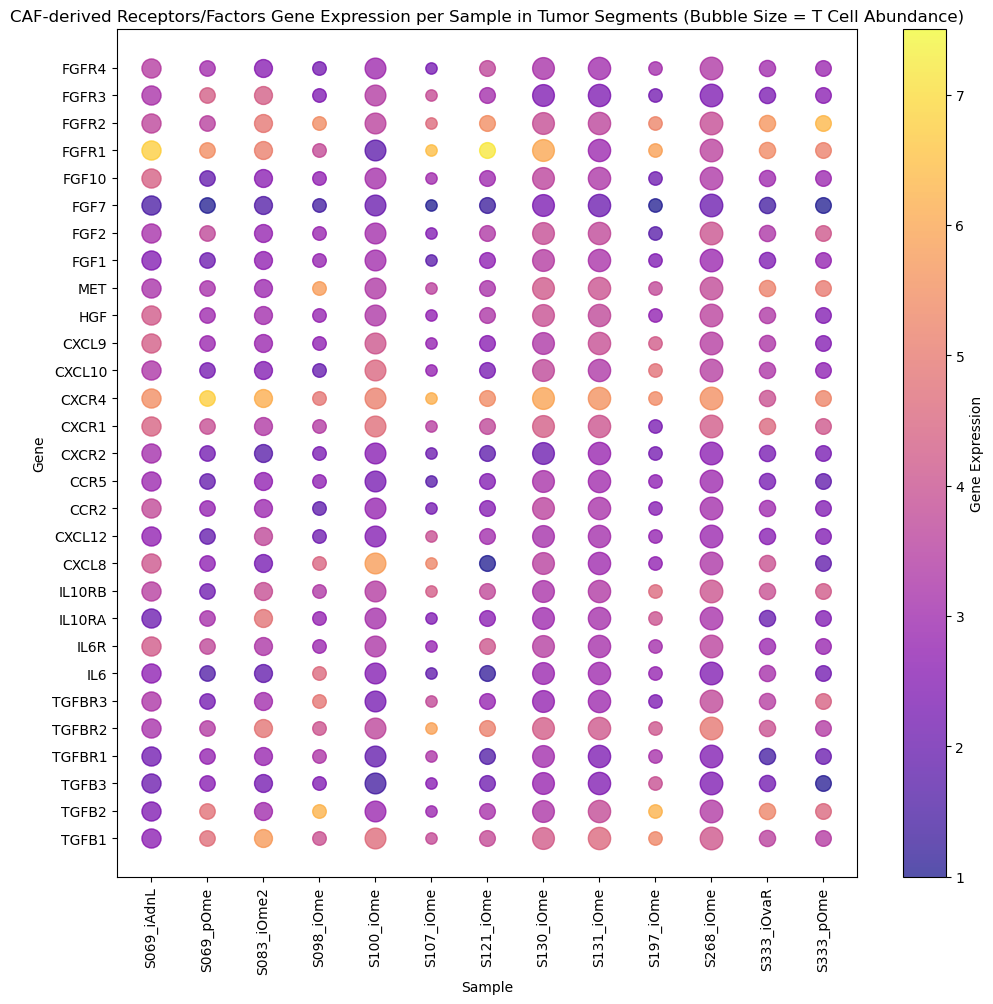

In [60]:
x_vals = merged_df_tcell_tumor_derived['Sample']
samples = merged_df_tcell_tumor_derived['Sample'].unique()
genes =genes_of_interest_receptors_targets

plt.figure(figsize=(len(samples)*0.8,len(genes)*0.35))
# Loop through genes to plot all combinations
vmina = []
vmaxa = []
for gene in genes:
    #vmina.append(merged_df_tcell_tumor_derived[gene].min())
    #vmaxa.append(merged_df_tcell_tumor_derived[gene].max())
    for i, sample in enumerate(samples):
        expression = merged_df_tcell_tumor_derived.loc[merged_df_tcell_tumor_derived['Sample'] == sample, gene].values[0]
        t_cells = merged_df_tcell_tumor_derived.loc[merged_df_tcell_tumor_derived['Sample'] == sample, 'Tcells'].values[0]
        
        plt.scatter(
            x=sample,
            y=gene,
            s=t_cells * 5500,  # scale bubble size as needed
            c=expression,
            cmap='plasma',
            vmin=1,  # consistent color scale
            vmax=7.5,
            alpha=0.7
        )

plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Gene")
plt.title("CAF-derived Receptors/Factors Gene Expression per Sample in Tumor Segments (Bubble Size = T Cell Abundance)")
plt.colorbar(label="Gene Expression")
plt.tight_layout()
plt.show()


In [61]:
df_tcell_abundance = pd.read_csv("bp_res_mid_lvl_ct_ct_fraction.csv")
df_tcell_abundance = df_tcell_abundance[["dcc_filename","Sample","Tcells"]]
df_gene_expression=gene_expression_modified
df_gene_expression

Unnamed: 0                 dcc_filename     FGFR2      IL6R      CCR5  \
0             1  DSP.1001660016604.A.A02.dcc  3.361754  3.598443  2.308785   
1             2  DSP.1001660016604.A.A04.dcc  3.193818  3.509266  3.432931   
2             3  DSP.1001660016604.A.A05.dcc  3.592371  3.585760  2.789620   
3             4  DSP.1001660016604.A.A07.dcc  4.263898  3.448090  3.748175   
4             5  DSP.1001660016604.A.A08.dcc  3.592490  2.519654  3.733214   
..          ...                          ...       ...       ...       ...   
189         190  DSP.1001660037247.C.D02.dcc  4.277910  2.770738  4.309911   
190         191  DSP.1001660037247.C.D03.dcc  7.289014  4.329459  3.163609   
191         192  DSP.1001660037247.C.D04.dcc  5.696289  1.054717  3.352850   
192         193  DSP.1001660037247.C.D05.dcc  7.233920  2.047122  0.548447   
193         194  DSP.1001660037247.C.D06.dcc  2.605100  3.975593  4.458266   

          HGF    IL10RB     TGFB1    TGFBR2      CCR2  ...     CXCL8  \
0    4.284057  2.643606  3.782934  4.211304  3.490294  ...  3.481467   
1    3.656575  4.222768  5.312708  4.060718  3.310616  ...  2.659595   
2    3.923520  2.913399  3.859592  4.513373  3.488150  ...  3.016881   
3    4.267320  3.580283  4.988758  4.244939  3.792199  ...  4.046040   
4    4.342483  3.709352  4.899960  3.900900  2.715060  ...  3.563410   
..        ...       ...       ...       ...       ...  ...       ...   
189  3.393038  3.972500  6.334667  5.911482  3.924523  ...  2.396354   
190  0.981959  4.264143  4.114525  3.345048  2.597749  ...  0.508454   
191  4.825368  4.988569  5.632562  5.853667  3.906748  ...  0.288400   
192  3.290937  4.166872  3.025344  3.246448  1.385948  ...  2.054575   
193  3.543807  3.149536  5.930979  5.726414  3.845015  ...  2.147237   

          IL6     CXCR1     FGF10     Sample  PFS_quartile  OS_quartile  \
0    2.998769  5.090631  3.105129  S130_iOme             1            1   
1    3.625401  4.707195  3.724372  S130_iOme             1            1   
2    3.000984  4.117627  3.778433  S130_iOme             1            1   
3    3.034237  4.881722  4.301300  S130_iOme             1            1   
4    3.661552  3.364460  3.932246  S130_iOme             1            1   
..        ...       ...       ...        ...           ...          ...   
189  2.047406  3.869936  3.404106  S333_pOme             3            1   
190  2.845793  3.992833  1.837595  S333_pOme             3            1   
191  0.331385  2.796994  3.337978  S333_pOme             3            1   
192  1.725636  4.064308  2.462543  S333_pOme             3            1   
193  0.313732  3.325268  3.276580  S333_pOme             3            1   

     BRCA_status  HRP_status  Segment  
0            0.0         1.0   stroma  
1            0.0         1.0   stroma  
2            0.0         1.0    tumor  
3            0.0         1.0    tumor  
4            0.0         1.0   stroma  
..           ...         ...      ...  
189          0.0         1.0   stroma  
190          0.0         1.0    tumor  
191          0.0         1.0   stroma  
192          0.0         1.0    tumor  
193          0.0         1.0   stroma  

[194 rows x 45 columns]

In [62]:
df_tcell_genes = df_gene_expression.merge(df_tcell_abundance[['dcc_filename', 'Tcells']], on='dcc_filename', how='left')
df_tcell_genes

Unnamed: 0                 dcc_filename     FGFR2      IL6R      CCR5  \
0             1  DSP.1001660016604.A.A02.dcc  3.361754  3.598443  2.308785   
1             2  DSP.1001660016604.A.A04.dcc  3.193818  3.509266  3.432931   
2             3  DSP.1001660016604.A.A05.dcc  3.592371  3.585760  2.789620   
3             4  DSP.1001660016604.A.A07.dcc  4.263898  3.448090  3.748175   
4             5  DSP.1001660016604.A.A08.dcc  3.592490  2.519654  3.733214   
..          ...                          ...       ...       ...       ...   
189         190  DSP.1001660037247.C.D02.dcc  4.277910  2.770738  4.309911   
190         191  DSP.1001660037247.C.D03.dcc  7.289014  4.329459  3.163609   
191         192  DSP.1001660037247.C.D04.dcc  5.696289  1.054717  3.352850   
192         193  DSP.1001660037247.C.D05.dcc  7.233920  2.047122  0.548447   
193         194  DSP.1001660037247.C.D06.dcc  2.605100  3.975593  4.458266   

          HGF    IL10RB     TGFB1    TGFBR2      CCR2  ...       IL6  \
0    4.284057  2.643606  3.782934  4.211304  3.490294  ...  2.998769   
1    3.656575  4.222768  5.312708  4.060718  3.310616  ...  3.625401   
2    3.923520  2.913399  3.859592  4.513373  3.488150  ...  3.000984   
3    4.267320  3.580283  4.988758  4.244939  3.792199  ...  3.034237   
4    4.342483  3.709352  4.899960  3.900900  2.715060  ...  3.661552   
..        ...       ...       ...       ...       ...  ...       ...   
189  3.393038  3.972500  6.334667  5.911482  3.924523  ...  2.047406   
190  0.981959  4.264143  4.114525  3.345048  2.597749  ...  2.845793   
191  4.825368  4.988569  5.632562  5.853667  3.906748  ...  0.331385   
192  3.290937  4.166872  3.025344  3.246448  1.385948  ...  1.725636   
193  3.543807  3.149536  5.930979  5.726414  3.845015  ...  0.313732   

        CXCR1     FGF10     Sample  PFS_quartile  OS_quartile  BRCA_status  \
0    5.090631  3.105129  S130_iOme             1            1          0.0   
1    4.707195  3.724372  S130_iOme             1            1          0.0   
2    4.117627  3.778433  S130_iOme             1            1          0.0   
3    4.881722  4.301300  S130_iOme             1            1          0.0   
4    3.364460  3.932246  S130_iOme             1            1          0.0   
..        ...       ...        ...           ...          ...          ...   
189  3.869936  3.404106  S333_pOme             3            1          0.0   
190  3.992833  1.837595  S333_pOme             3            1          0.0   
191  2.796994  3.337978  S333_pOme             3            1          0.0   
192  4.064308  2.462543  S333_pOme             3            1          0.0   
193  3.325268  3.276580  S333_pOme             3            1          0.0   

     HRP_status  Segment  Tcells  
0           1.0   stroma     NaN  
1           1.0   stroma     NaN  
2           1.0    tumor     NaN  
3           1.0    tumor     NaN  
4           1.0   stroma     NaN  
..          ...      ...     ...  
189         1.0   stroma     NaN  
190         1.0    tumor     NaN  
191         1.0   stroma     NaN  
192         1.0    tumor     NaN  
193         1.0   stroma     NaN  

[194 rows x 46 columns]

In [63]:

df_tcell_abundance["dcc_filename"] = df_tcell_abundance["dcc_filename"].str.replace('-', '.', regex=False)
df_tcell_abundance


dcc_filename     Sample    Tcells
0    DSP.1001660016604.A.A02.dcc  S130_iOme  0.048908
1    DSP.1001660016604.A.A04.dcc  S130_iOme  0.049735
2    DSP.1001660016604.A.A05.dcc  S130_iOme  0.044657
3    DSP.1001660016604.A.A07.dcc  S130_iOme  0.045529
4    DSP.1001660016604.A.A08.dcc  S130_iOme  0.051026
..                           ...        ...       ...
189  DSP.1001660037247.C.D02.dcc  S333_pOme  0.029929
190  DSP.1001660037247.C.D03.dcc  S333_pOme  0.020000
191  DSP.1001660037247.C.D04.dcc  S333_pOme  0.026897
192  DSP.1001660037247.C.D05.dcc  S333_pOme  0.018637
193  DSP.1001660037247.C.D06.dcc  S333_pOme  0.042164

[194 rows x 3 columns]

In [66]:
df_tcell_genes["Tcells"] = df_tcell_abundance["Tcells"]

Calculting the spearman correlation between Tcells in the AOI and gene of interest expression and plotting the relations

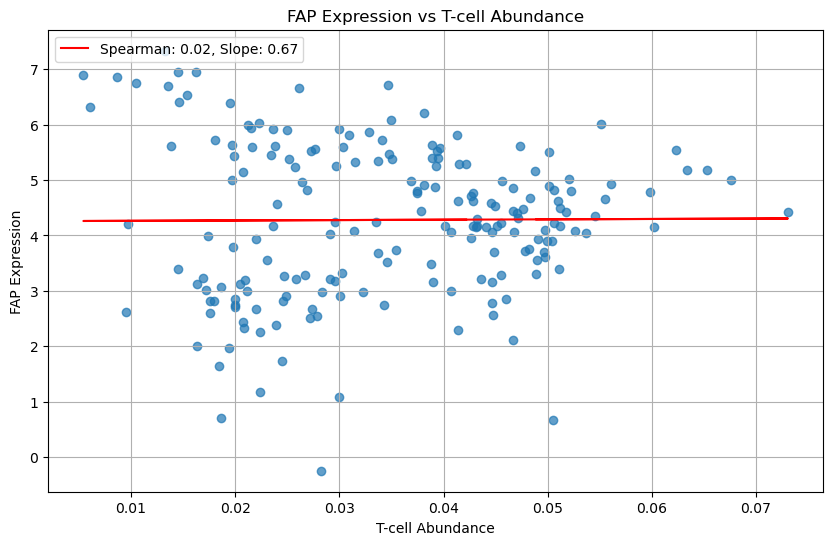

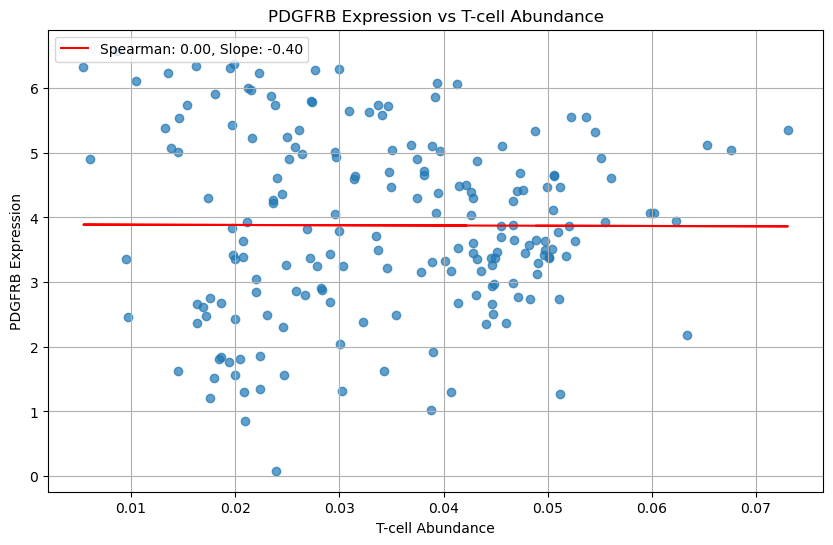

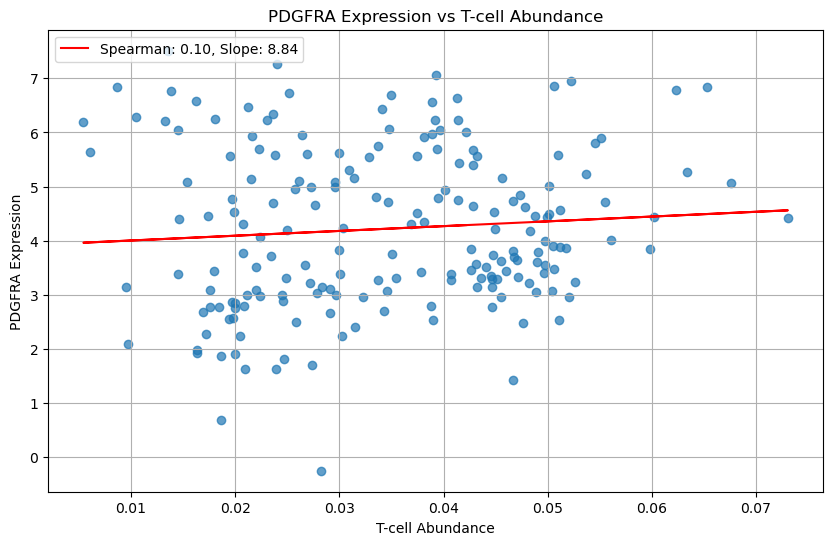

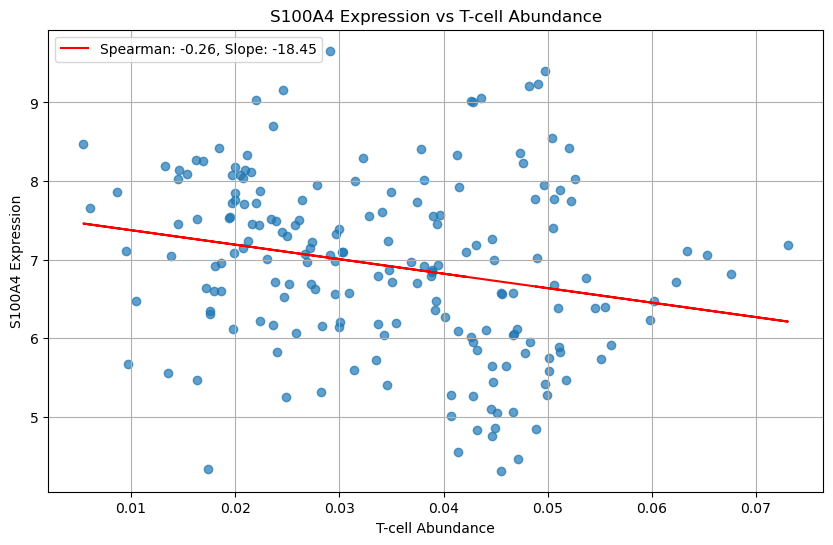

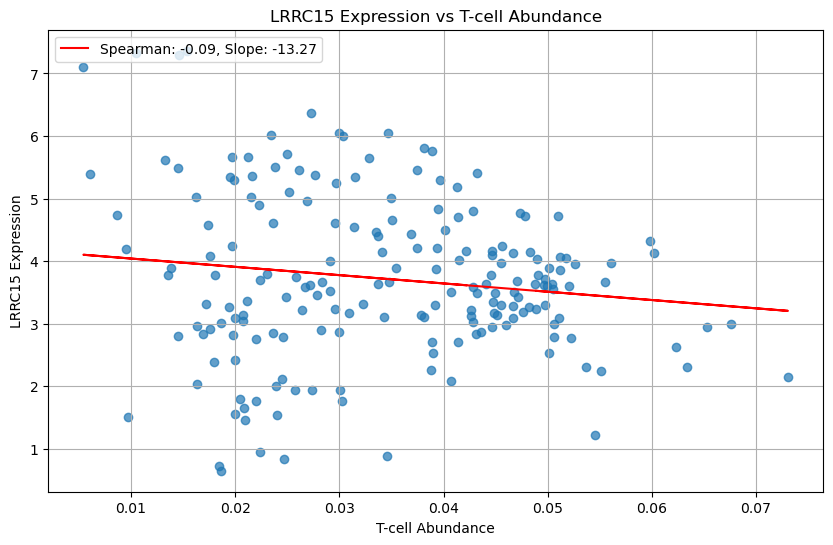

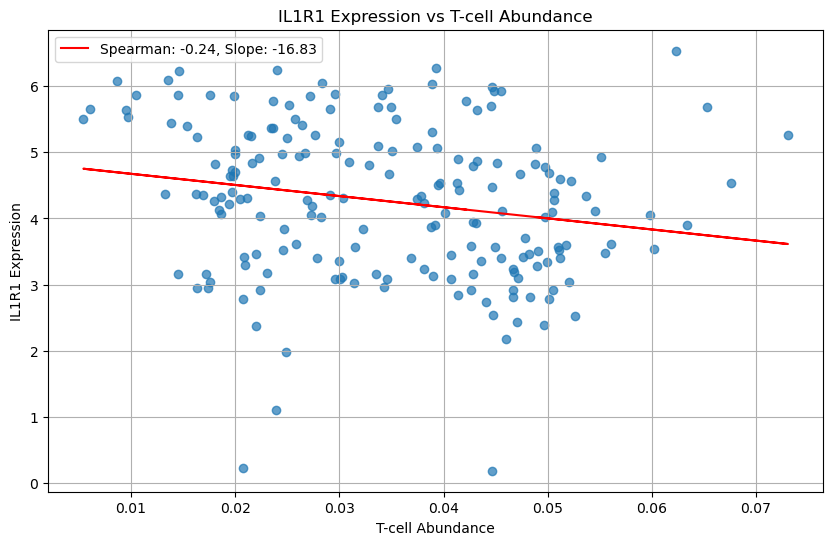

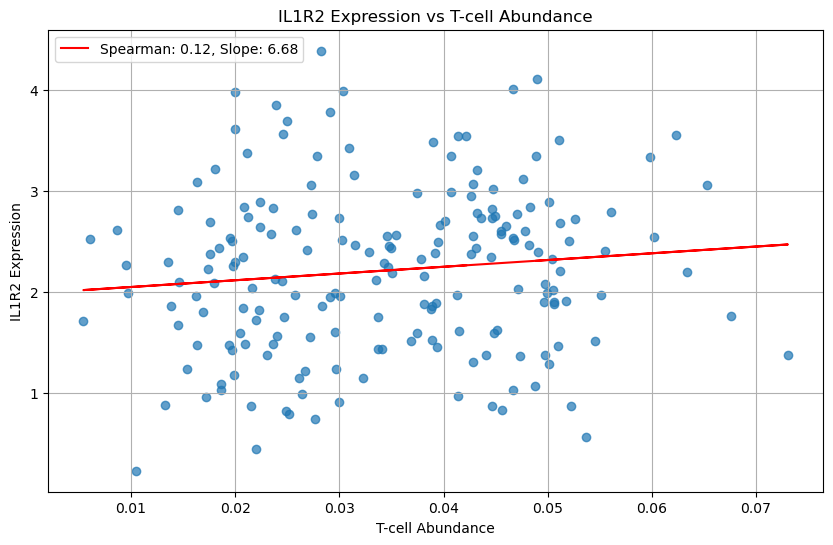

In [67]:
df_tcell_genes_filtered = df_tcell_genes[df_tcell_genes["Tcells"] < 0.1]



# Loop through each gene of interest
for gene in genes_of_interest_target:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for gene expression vs T-cell abundance
    plt.scatter(df_tcell_genes_filtered["Tcells"], df_tcell_genes_filtered[gene], alpha=0.7)
    
    # Calculate Spearman correlation coefficient
    spearman_corr, _ = spearmanr(df_tcell_genes_filtered["Tcells"], df_tcell_genes_filtered[gene])
    
    # Perform linear regression for plotting line of best fit
    slope, intercept, _, _, _ = linregress(df_tcell_genes_filtered["Tcells"], df_tcell_genes_filtered[gene])
    
    # Create a regression line (for visualization)
    regression_line = slope * df_tcell_genes_filtered["Tcells"] + intercept
    plt.plot(df_tcell_genes_filtered["Tcells"], regression_line, color='red', label=f'Spearman: {spearman_corr:.2f}, Slope: {slope:.2f}')
    
    # Add title and labels
    plt.title(f"{gene} Expression vs T-cell Abundance")
    plt.xlabel("T-cell Abundance")
    plt.ylabel(f"{gene} Expression")
    plt.grid()
    
    # Display legend
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.show()

In [68]:
df_tcell_genes_filtered_stroma= df_tcell_genes_filtered[df_tcell_genes_filtered["Segment"] == "stroma"]
df_tcell_genes_filtered_stroma

Unnamed: 0                 dcc_filename     FGFR2      IL6R      CCR5  \
0             1  DSP.1001660016604.A.A02.dcc  3.361754  3.598443  2.308785   
1             2  DSP.1001660016604.A.A04.dcc  3.193818  3.509266  3.432931   
4             5  DSP.1001660016604.A.A08.dcc  3.592490  2.519654  3.733214   
7             8  DSP.1001660016604.A.B02.dcc  4.059072  3.717685  2.932056   
8             9  DSP.1001660016604.A.B06.dcc  3.799664  2.768309  2.242682   
..          ...                          ...       ...       ...       ...   
185         186  DSP.1001660037247.C.C10.dcc  1.748735  2.807789  3.804959   
188         189  DSP.1001660037247.C.D01.dcc  2.993375  2.294694  5.325686   
189         190  DSP.1001660037247.C.D02.dcc  4.277910  2.770738  4.309911   
191         192  DSP.1001660037247.C.D04.dcc  5.696289  1.054717  3.352850   
193         194  DSP.1001660037247.C.D06.dcc  2.605100  3.975593  4.458266   

          HGF    IL10RB     TGFB1    TGFBR2      CCR2  ...       IL6  \
0    4.284057  2.643606  3.782934  4.211304  3.490294  ...  2.998769   
1    3.656575  4.222768  5.312708  4.060718  3.310616  ...  3.625401   
4    4.342483  3.709352  4.899960  3.900900  2.715060  ...  3.661552   
7    4.409065  3.008124  4.976537  4.303537  3.929709  ...  4.192371   
8    4.361210  3.367806  5.059482  4.108074  4.078876  ...  2.966410   
..        ...       ...       ...       ...       ...  ...       ...   
185  4.396199  3.519814  5.483295  5.842228  3.684697  ...  0.693491   
188  5.118038  2.466678  5.481055  6.403109  2.631561  ...  2.264111   
189  3.393038  3.972500  6.334667  5.911482  3.924523  ...  2.047406   
191  4.825368  4.988569  5.632562  5.853667  3.906748  ...  0.331385   
193  3.543807  3.149536  5.930979  5.726414  3.845015  ...  0.313732   

        CXCR1     FGF10     Sample  PFS_quartile  OS_quartile  BRCA_status  \
0    5.090631  3.105129  S130_iOme             1            1          0.0   
1    4.707195  3.724372  S130_iOme             1            1          0.0   
4    3.364460  3.932246  S130_iOme             1            1          0.0   
7    4.758217  4.307614  S130_iOme             1            1          0.0   
8    4.353730  2.852497  S130_iOme             1            1          0.0   
..        ...       ...        ...           ...          ...          ...   
185  4.566332  2.982687  S333_pOme             3            1          0.0   
188  3.886192  3.123440  S333_pOme             3            1          0.0   
189  3.869936  3.404106  S333_pOme             3            1          0.0   
191  2.796994  3.337978  S333_pOme             3            1          0.0   
193  3.325268  3.276580  S333_pOme             3            1          0.0   

     HRP_status  Segment    Tcells  
0           1.0   stroma  0.048908  
1           1.0   stroma  0.049735  
4           1.0   stroma  0.051026  
7           1.0   stroma  0.049932  
8           1.0   stroma  0.056117  
..          ...      ...       ...  
185         1.0   stroma  0.027617  
188         1.0   stroma  0.053690  
189         1.0   stroma  0.029929  
191         1.0   stroma  0.026897  
193         1.0   stroma  0.042164  

[107 rows x 46 columns]

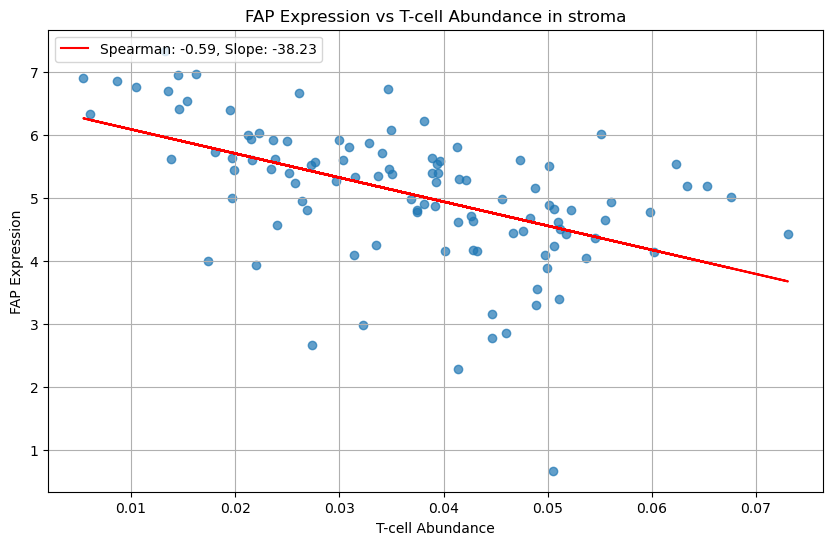

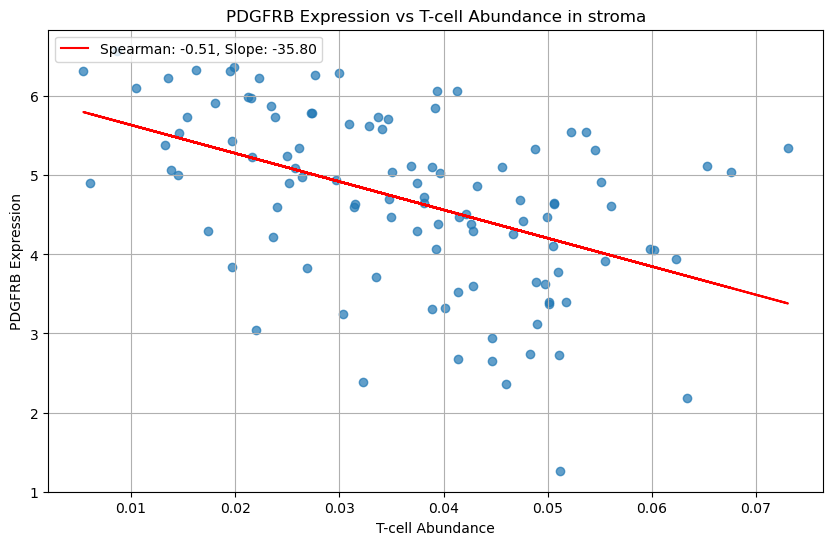

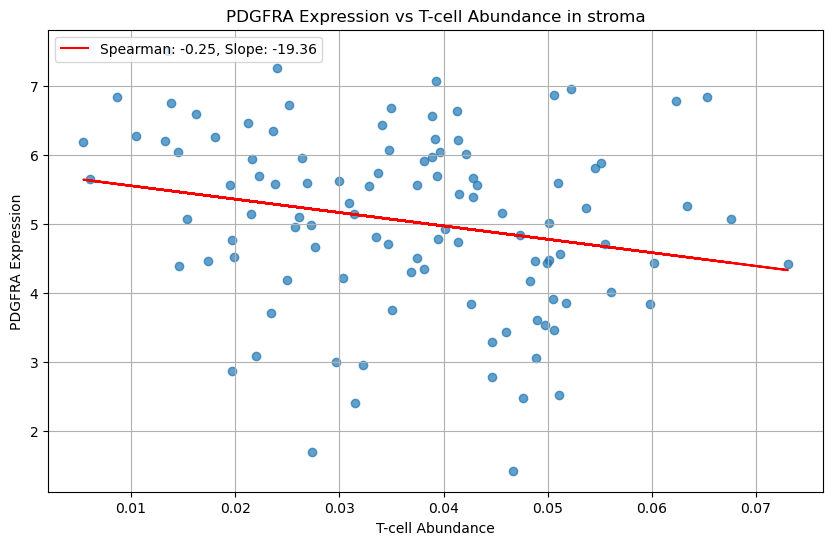

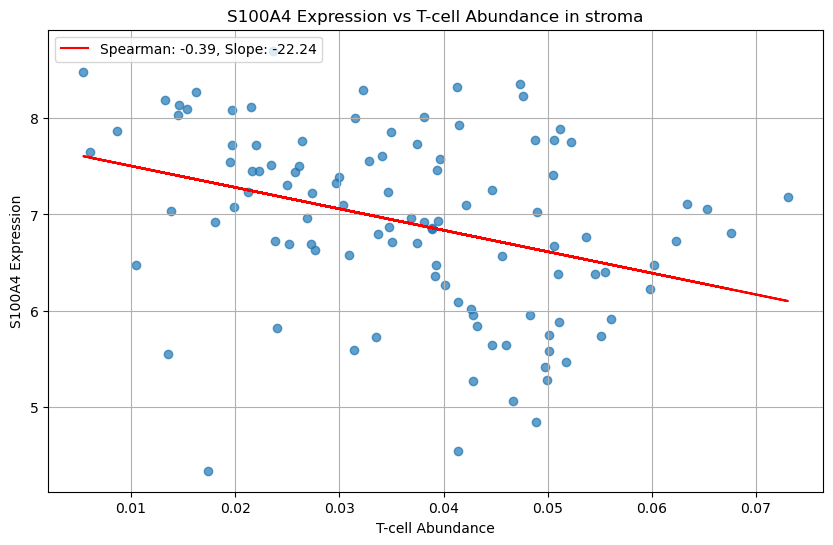

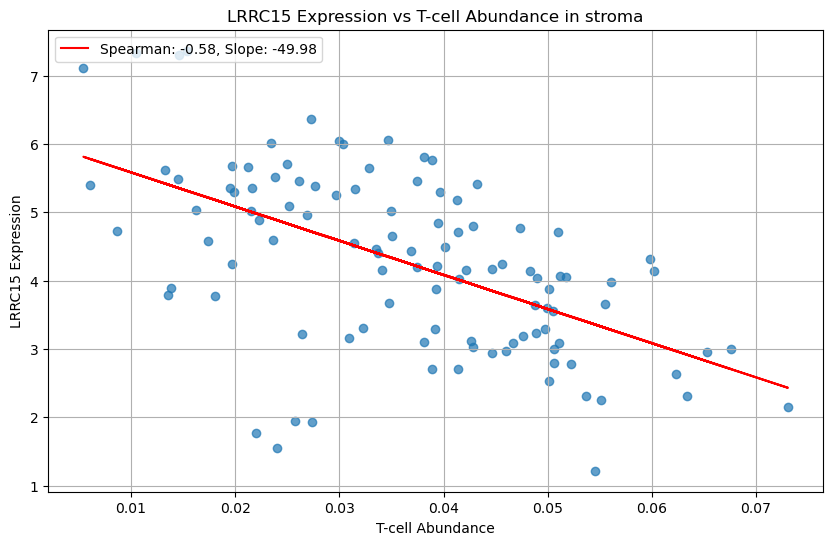

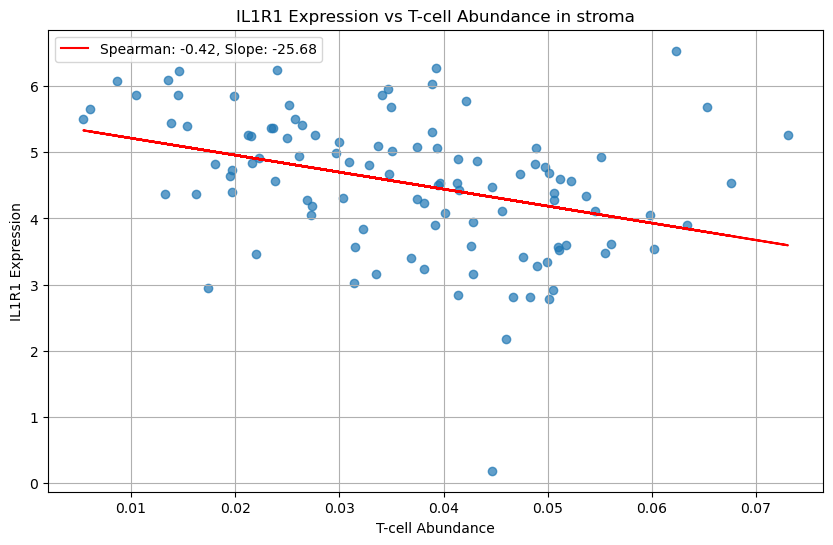

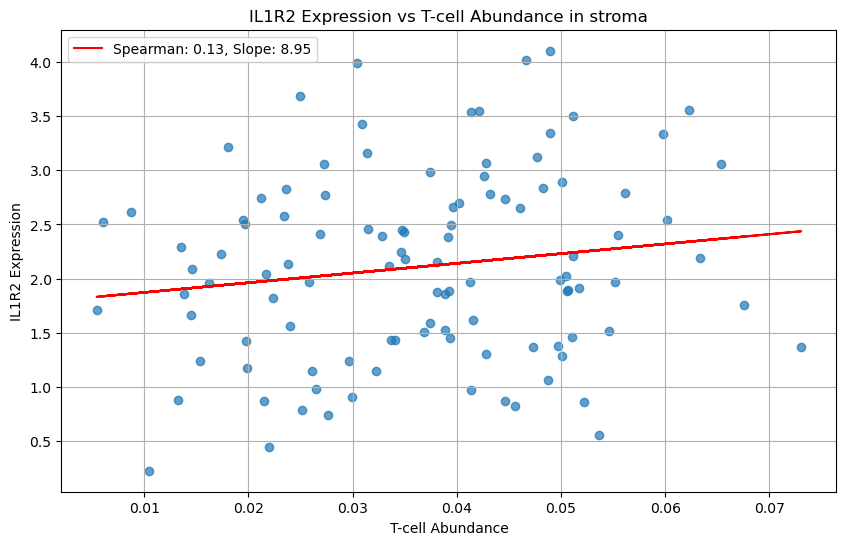

In [69]:
for gene in genes_of_interest_target:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for gene expression vs T-cell abundance
    plt.scatter(df_tcell_genes_filtered_stroma["Tcells"], df_tcell_genes_filtered_stroma[gene], alpha=0.7)
    
    # Calculate Spearman correlation coefficient
    spearman_corr, _ = spearmanr(df_tcell_genes_filtered_stroma["Tcells"], df_tcell_genes_filtered_stroma[gene])
    
    # Perform linear regression for plotting line of best fit
    slope, intercept, _, _, _ = linregress(df_tcell_genes_filtered_stroma["Tcells"], df_tcell_genes_filtered_stroma[gene])
    
    # Create a regression line (for visualization)
    regression_line = slope * df_tcell_genes_filtered_stroma["Tcells"] + intercept
    plt.plot(df_tcell_genes_filtered_stroma["Tcells"], regression_line, color='red', label=f'Spearman: {spearman_corr:.2f}, Slope: {slope:.2f}')
    
    # Add title and labels
    plt.title(f"{gene} Expression vs T-cell Abundance in stroma")
    plt.xlabel("T-cell Abundance")
    plt.ylabel(f"{gene} Expression")
    plt.grid()
    
    # Display legend
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.show()

In [70]:
df_tcell_genes_filtered_tumor= df_tcell_genes_filtered[df_tcell_genes_filtered["Segment"] == "tumor"]
df_tcell_genes_filtered_tumor

Unnamed: 0                 dcc_filename     FGFR2      IL6R      CCR5  \
2             3  DSP.1001660016604.A.A05.dcc  3.592371  3.585760  2.789620   
3             4  DSP.1001660016604.A.A07.dcc  4.263898  3.448090  3.748175   
5             6  DSP.1001660016604.A.A09.dcc  4.016844  3.262927  3.371962   
6             7  DSP.1001660016604.A.B01.dcc  3.563630  3.467260  2.559535   
9            10  DSP.1001660016604.A.B07.dcc  3.987423  3.727761  3.559503   
..          ...                          ...       ...       ...       ...   
184         185  DSP.1001660037247.C.C09.dcc  6.948235  2.548377  1.620594   
186         187  DSP.1001660037247.C.C11.dcc  6.458353  1.933677  1.249536   
187         188  DSP.1001660037247.C.C12.dcc  6.471002  2.637030  2.589431   
190         191  DSP.1001660037247.C.D03.dcc  7.289014  4.329459  3.163609   
192         193  DSP.1001660037247.C.D05.dcc  7.233920  2.047122  0.548447   

          HGF    IL10RB     TGFB1    TGFBR2      CCR2  ...       IL6  \
2    3.923520  2.913399  3.859592  4.513373  3.488150  ...  3.000984   
3    4.267320  3.580283  4.988758  4.244939  3.792199  ...  3.034237   
5    3.820901  3.496185  4.124346  3.917691  4.091774  ...  2.368962   
6    3.960309  3.680492  4.472503  4.591287  3.201860  ...  3.314957   
9    3.739972  2.425620  3.752964  4.078315  3.457067  ...  2.699637   
..        ...       ...       ...       ...       ...  ...       ...   
184  3.042832  3.645738  3.851009  4.179944  2.544562  ...  1.326822   
186  3.142823  3.468200  1.707043  4.250367  2.661782  ...  1.959386   
187  1.750949  4.483239  4.630553  4.420768  1.235568  ...  1.913698   
190  0.981959  4.264143  4.114525  3.345048  2.597749  ...  2.845793   
192  3.290937  4.166872  3.025344  3.246448  1.385948  ...  1.725636   

        CXCR1     FGF10     Sample  PFS_quartile  OS_quartile  BRCA_status  \
2    4.117627  3.778433  S130_iOme             1            1          0.0   
3    4.881722  4.301300  S130_iOme             1            1          0.0   
5    3.826462  3.937070  S130_iOme             1            1          0.0   
6    4.036185  3.245078  S130_iOme             1            1          0.0   
9    4.631174  2.854885  S130_iOme             1            1          0.0   
..        ...       ...        ...           ...          ...          ...   
184  3.898063  2.080726  S333_pOme             3            1          0.0   
186  3.561849  3.383835  S333_pOme             3            1          0.0   
187  3.948303  2.716666  S333_pOme             3            1          0.0   
190  3.992833  1.837595  S333_pOme             3            1          0.0   
192  4.064308  2.462543  S333_pOme             3            1          0.0   

     HRP_status  Segment    Tcells  
2           1.0    tumor  0.044657  
3           1.0    tumor  0.045529  
5           1.0    tumor  0.043227  
6           1.0    tumor  0.044573  
9           1.0    tumor  0.045102  
..          ...      ...       ...  
184         1.0    tumor  0.020437  
186         1.0    tumor  0.022359  
187         1.0    tumor  0.020874  
190         1.0    tumor  0.020000  
192         1.0    tumor  0.018637  

[84 rows x 46 columns]

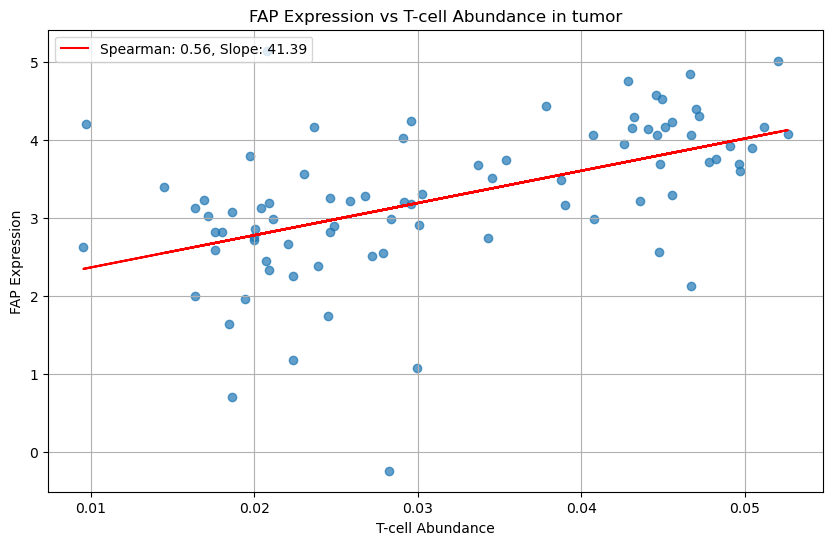

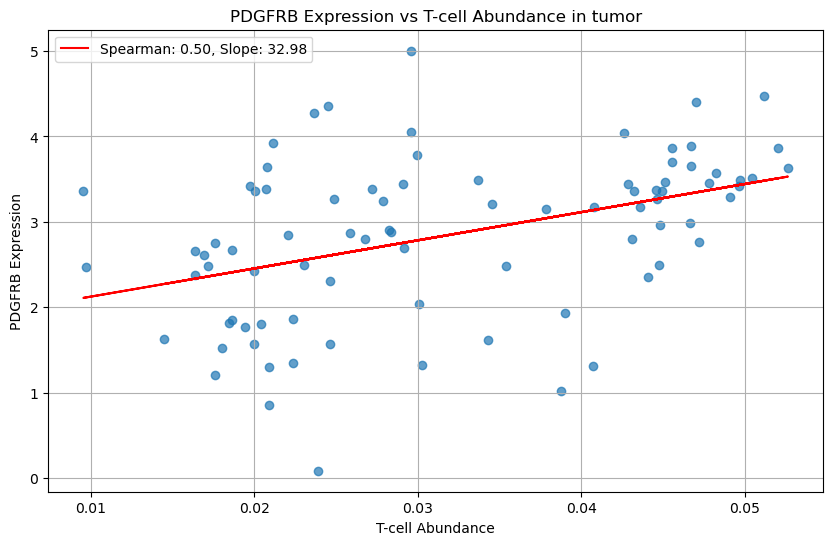

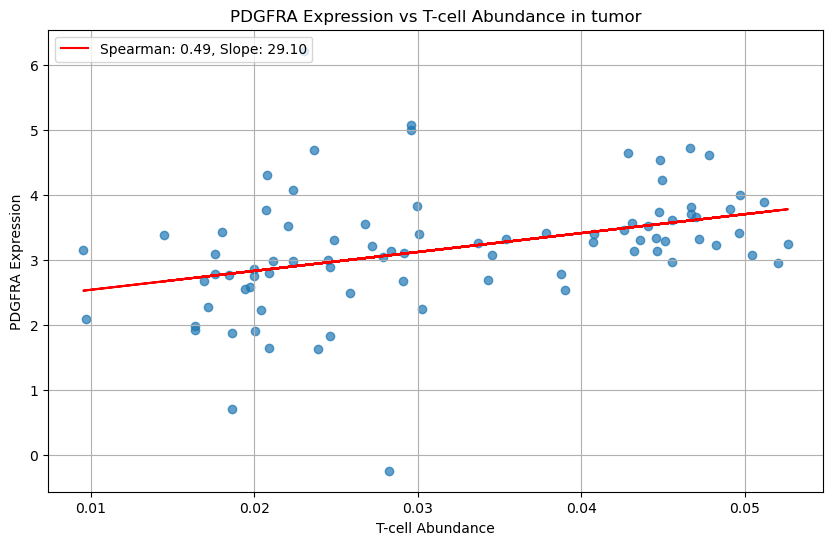

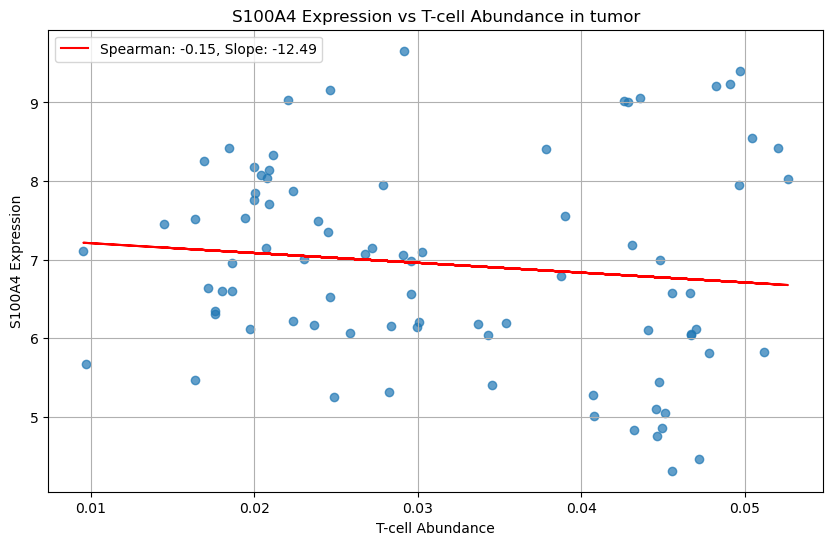

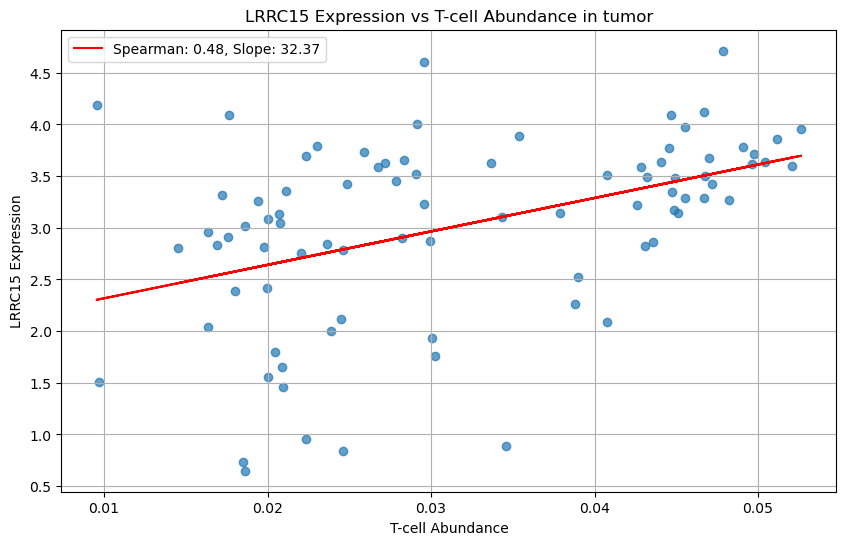

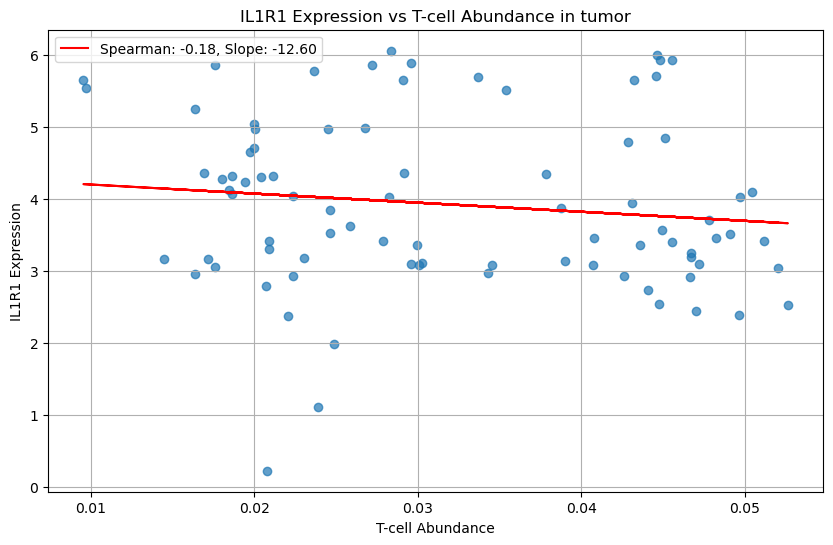

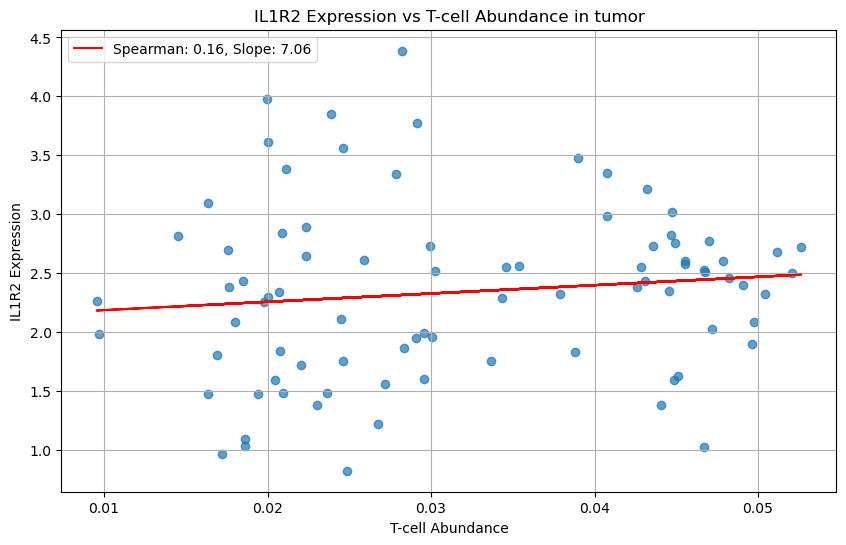

In [71]:
for gene in genes_of_interest_target:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for gene expression vs T-cell abundance
    plt.scatter(df_tcell_genes_filtered_tumor["Tcells"], df_tcell_genes_filtered_tumor[gene], alpha=0.7)
    
    # Calculate Spearman correlation coefficient
    spearman_corr, _ = spearmanr(df_tcell_genes_filtered_tumor["Tcells"], df_tcell_genes_filtered_tumor[gene])
    
    # Perform linear regression for plotting line of best fit
    slope, intercept, _, _, _ = linregress(df_tcell_genes_filtered_tumor["Tcells"], df_tcell_genes_filtered_tumor[gene])
    
    # Create a regression line (for visualization)
    regression_line = slope * df_tcell_genes_filtered_tumor["Tcells"] + intercept
    plt.plot(df_tcell_genes_filtered_tumor["Tcells"], regression_line, color='red', label=f'Spearman: {spearman_corr:.2f}, Slope: {slope:.2f}')
    
    # Add title and labels
    plt.title(f"{gene} Expression vs T-cell Abundance in tumor")
    plt.xlabel("T-cell Abundance")
    plt.ylabel(f"{gene} Expression")
    plt.grid()
    
    # Display legend
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.show()

In [39]:
genes_of_interest_target=["FAP","PDGFRB",'PDGFRA', 'S100A4', "LRRC15","IL1R1","IL1R2"]

gene_expression_modified_stroma = gene_expression_modified[gene_expression_modified["Segment"] == "stroma"]

all_genes_heatmap_stroma = gene_expression_modified_stroma.groupby("Sample")[genes_of_interest_target].mean()

df_tcell_abundance_stroma=df_tcell_abundance[df_tcell_abundance["Segment"] == "stroma"]

df_tcell_abundance_mean_stroma=df_tcell_abundance_stroma.groupby("Sample")["Tcells"].mean()
df_tcell_abundance_mean_stroma


merged_df_tcell_stroma=pd.merge(df_tcell_abundance_mean_stroma, all_genes_heatmap_stroma, on="Sample", how="left")
merged_df_tcell_stroma["Sample"]=merged_df_tcell_stroma.index

In [103]:
df_tcell_abundance

dcc_filename     Sample    Tcells
0    DSP.1001660016604.A.A02.dcc  S130_iOme  0.048908
1    DSP.1001660016604.A.A04.dcc  S130_iOme  0.049735
2    DSP.1001660016604.A.A05.dcc  S130_iOme  0.044657
3    DSP.1001660016604.A.A07.dcc  S130_iOme  0.045529
4    DSP.1001660016604.A.A08.dcc  S130_iOme  0.051026
..                           ...        ...       ...
189  DSP.1001660037247.C.D02.dcc  S333_pOme  0.029929
190  DSP.1001660037247.C.D03.dcc  S333_pOme  0.020000
191  DSP.1001660037247.C.D04.dcc  S333_pOme  0.026897
192  DSP.1001660037247.C.D05.dcc  S333_pOme  0.018637
193  DSP.1001660037247.C.D06.dcc  S333_pOme  0.042164

[194 rows x 3 columns]

1.355614809160168 2.621412954948121


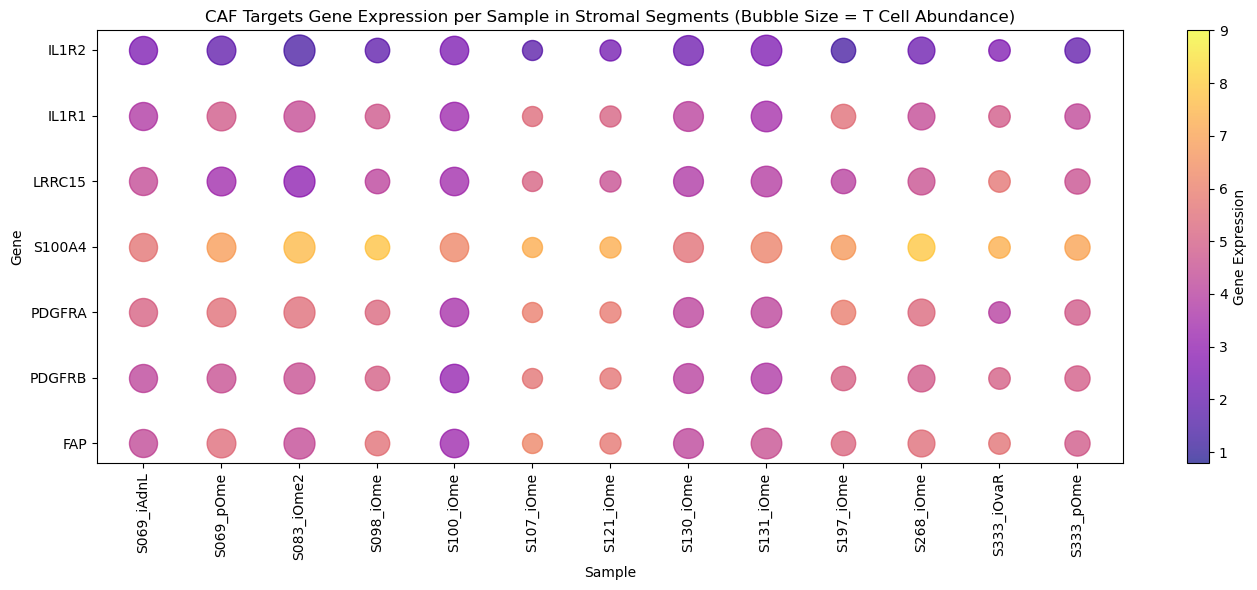

[3.3102116903840524, 3.0992780134628077, 3.541533948905208, 5.565705655619894, 2.9395839818721767, 3.3191713472278774, 1.355614809160168]
[6.198171759515119, 5.681032385118276, 5.97941818965747, 7.898361876392895, 5.718435260340268, 5.537050289394721, 2.621412954948121]


In [41]:

plt.figure(figsize=(14, 6))

# Get coordinates for x (samples) and y (genes)
x_vals = merged_df_tcell_stroma['Sample']
samples = merged_df_tcell_stroma['Sample'].unique()
genes = genes_of_interest_target


vmina=[]
vmaxa=[]
# Loop through genes to plot all combinations
for gene in genes:
    vmina.append(merged_df_tcell_stroma[gene].min())
    vmaxa.append(merged_df_tcell_stroma[gene].max())
    for i, sample in enumerate(samples):
        expression = merged_df_tcell_stroma.loc[merged_df_tcell_stroma['Sample'] == sample, gene].values[0]
        t_cells = merged_df_tcell_stroma.loc[merged_df_tcell_stroma['Sample'] == sample, 'Tcells'].values[0]
        
        plt.scatter(
            x=sample,
            y=gene,
            s=t_cells * 9000,  # scale bubble size as needed
            c=expression,
            cmap='plasma',
            vmin=0.8,  # consistent color scale
            vmax=9,
            alpha=0.7
        )
        

vmin=merged_df_tcell_stroma[gene].min()  # consistent color scale
vmax=merged_df_tcell_stroma[gene].max()
print(vmin,vmax)
plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Gene")
plt.title("CAF Targets Gene Expression per Sample in Stromal Segments (Bubble Size = T Cell Abundance)")
plt.colorbar(label="Gene Expression")
plt.tight_layout()
plt.show()
print(vmina)
print(vmaxa)

In [42]:
genes_of_interest_target=["FAP","PDGFRB",'PDGFRA', 'S100A4', "LRRC15","IL1R1","IL1R2"]

gene_expression_modified_tumor = gene_expression_modified[gene_expression_modified["Segment"] == "tumor"]

all_genes_heatmap_tumor = gene_expression_modified_tumor.groupby("Sample")[genes_of_interest_target].mean()

df_tcell_abundance_tumor=df_tcell_abundance[df_tcell_abundance["Segment"] == "tumor"]

df_tcell_abundance_mean_tumor=df_tcell_abundance_tumor.groupby("Sample")["Tcells"].mean()
df_tcell_abundance_mean_tumor


merged_df_tcell_tumor=pd.merge(df_tcell_abundance_mean_tumor, all_genes_heatmap_tumor, on="Sample", how="left")
merged_df_tcell_tumor["Sample"]=merged_df_tcell_tumor.index

1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121
1.355614809160168 2.621412954948121


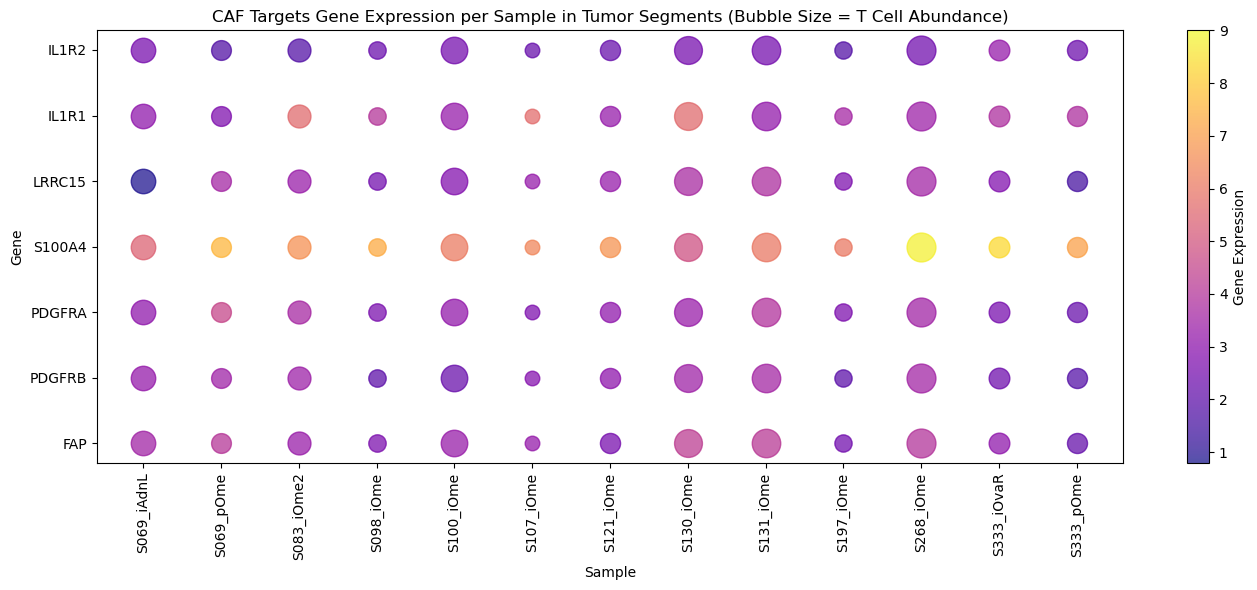

[2.135228991896711, 1.7972994114896188, 2.1889135236281394, 4.809329589061798, 0.886366766613509, 2.70999728390279, 1.7522826003499676]
[4.26518417759883, 3.5671605306709124, 4.569865898938428, 8.789482323726125, 3.7867298712960538, 5.67840078103796, 3.245482169416274]


In [43]:
plt.figure(figsize=(14, 6))

# Get coordinates for x (samples) and y (genes)
x_vals = merged_df_tcell_tumor['Sample']
samples = merged_df_tcell_tumor['Sample'].unique()
genes = genes_of_interest_target
vmina=[]
vmaxa=[]
# Loop through genes to plot all combinations
for gene in genes:
    vmina.append(merged_df_tcell_tumor[gene].min())
    vmaxa.append(merged_df_tcell_tumor[gene].max())
    print(vmin,vmax)
    for i, sample in enumerate(samples):
        expression = merged_df_tcell_tumor.loc[merged_df_tcell_tumor['Sample'] == sample, gene].values[0]
        t_cells = merged_df_tcell_tumor.loc[merged_df_tcell_tumor['Sample'] == sample, 'Tcells'].values[0]
        
        plt.scatter(
            x=sample,
            y=gene,
            s=t_cells * 9000,  # scale bubble size as needed
            c=expression,
            cmap='plasma',
            vmin=0.8,  # consistent color scale
            vmax=9,
            alpha=0.7
        )

print(vmin,vmax)
plt.xticks(rotation=90)
plt.xlabel("Sample")
plt.ylabel("Gene")
plt.title("CAF Targets Gene Expression per Sample in Tumor Segments (Bubble Size = T Cell Abundance)")
plt.colorbar(label="Gene Expression")
plt.tight_layout()
plt.show()
print(vmina)
print(vmaxa)